<h1><center>Metody uczenia maszynowego</center></h1>
<h3><center><ul style="list-style: none;">
    <li>Patrycja Szczakowska 234121</li>
    <li>Maciej Majchrowski 234088</li>
    <li>Bartosz Janicki 234065</li>
    <li>Mateusz Gałasiński 234054</li>
    <li>Jakub Kurek 234078</li>
    </ul></center></h3> 
<h2><center>Zadanie 2 - Klastryzacja danych - uczenie nienadzorowane</center></h2>

### Zależności
*Dodatkowe zewnętrzne biblioteki, instalowane dzięki IPython "magic commands"*

In [ ]:
# install additional packages
!pip install k3d > /dev/null
!pip install fuzzy-c-means > /dev/null

### Imports

In [ ]:
from pathlib import Path
import matplotlib
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # Do not warn about high memory consumption
from pandas import read_csv
import json
%matplotlib notebook

In [ ]:
import sklearn
from uuid import uuid4
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import calinski_harabasz_score, pairwise_distances, davies_bouldin_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, homogeneity_completeness_v_measure, v_measure_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS, cluster_optics_dbscan
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np
from fcmeans import FCM

## Konfiguracja

In [ ]:
class Config(object):
    def __init__(self, dataSourceUrl, dataDelimiter, n_clusters, eps, min_samples, xi, min_cluster_size, m, ndims):
        self.dataSourceUrl = dataSourceUrl
        self.dataDelimiter = dataDelimiter
        self.n_clusters = n_clusters
        self.eps = eps
        self.min_samples = min_samples
        self.xi = xi
        self.min_cluster_size = min_cluster_size
        self.m = m
        self.ndims = ndims
def as_config(dct):
    return Config(
        dct['dataSourceUrl'],
        dct['dataDelimiter'],
        dct['n_clusters'],
        dct['eps'],
        dct['min_samples'],
        dct['xi'],
        dct['min_cluster_size'],
        dct['m'],
        dct['ndims'],
    )

## Wczytanie zbioru danych

In [ ]:
# from pandas.plotting import scatter_matrix

def load_dataset():
    # show 5 rows from data
    for line in [line for line in Path(config.dataSourceUrl).read_text().splitlines()[:5] if line]:
        print(line)

    global dataset
    dataset = read_csv(config.dataSourceUrl, delimiter=config.dataDelimiter, header=0)
    print(f"Data set shape: {dataset.shape}")
    dataset.describe()

In [ ]:
from math import sqrt
def annot_elbow(x,y,ax=None):
    arg = x[0]
    val = y[0]
    for i, a in enumerate(x):
        if (a+2)*sqrt(y[i]) < (arg+2)*sqrt(val):
            arg = a
            val = y[i]
    text= "x={:.3f}".format(arg)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data',textcoords="axes fraction",
              bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(arg, val), xytext=(0.5,-0.05), **kw)

In [178]:
def scatter3d(x, labels):
    fig = plt.figure(figsize=(12, 6), dpi=60)
    ax = plt.axes(projection="3d")
    ax.scatter3D(x[:, 0:1], x[:, 1:2], x[:, 2:3], c=labels, cmap='inferno');
    plt.show()

In [180]:
def classify_each(x, labels_true=None):
    models = []
    models.extend([
        (f"AgglomerativeClustering-{linkage}", AgglomerativeClustering(linkage=linkage, n_clusters=config.n_clusters))
        for linkage in ['ward', 'average', 'complete', 'single']])
    models.extend([
        (f"GaussianMixture-{covariance_type}", GaussianMixture(n_components=config.n_clusters, covariance_type=covariance_type))
        for covariance_type in ['full', 'tied', 'diag', 'spherical']])
    models.extend([
        ('DBSCAN', DBSCAN(eps=config.eps, min_samples=config.min_samples)),
        ('OPTICS', OPTICS(min_samples=config.min_samples, xi=config.xi, min_cluster_size=config.min_cluster_size)),
        ('KMeans', KMeans(n_clusters=config.n_clusters, random_state=1)),
        ('FCM', FCM(n_clusters=config.n_clusters, m=config.m))
    ])

    results = []
    names = []
    for i, (name, model) in enumerate(models):
        print(f"-------------------------------------------------------------------------------------------")
        print(f"--------------------- Running clustering for: {name} ---------------------")
        labels = []
        if 'GaussianMixture' in name:
            labels = model.fit_predict(x)
        elif 'OPTICS' in name:
            clustering = model.fit(x)
            labels = model.labels_
        elif 'FCM' in name:
            clustering = model.fit(x)
            labels  = model.u.argmax(axis=1)
        else:
            clustering = model.fit(x)
            labels=clustering.labels_
    ### Results 
        if labels_true:
            print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
            print("Completeness: %0.3f" % completeness_score(labels_true, labels))
            print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
            print("Adjusted Rand Index: %0.3f" % adjusted_rand_score(labels_true, labels))
            print("Adjusted Mutual Information: %0.3f" % adjusted_mutual_info_score(labels_true, labels))
        if len(set(labels)) > 1:
            print(f"Davies-Bouldin index ""(lower->better)"f" : {davies_bouldin_score(x, labels)}")
            print("Silhouette Coefficient ""(-1->bad, 0->clusters overlap, 1+->better)"": %0.3f" % silhouette_score(x, labels))
            print("Calinski-Harabasz score ""(higher->better)"": %0.3f" % calinski_harabasz_score(x, labels))
        print(f"n_clusters_: {len(set(labels)) - (1 if -1 in labels else 0)}")
        print(f"n_noise_: {list(labels).count(-1)}")

    ### Plots
        if config.ndims == 3:
            scatter3d(x, labels)
        else:
            fig, axes = plt.subplots(1, 1, figsize=(8,8))
            fig.suptitle(name)
            # Black removed and is used for noise instead.
            unique_labels = set(labels)
            colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
            core_samples_mask = np.zeros_like(labels, dtype=bool)
            if name == "DBSCAN":
                core_samples_mask[clustering.core_sample_indices_] = True
            for k, col in zip(unique_labels, colors):
                if k == -1:
                    # Black used for noise.
                    col = [0, 0, 0, 1]

                class_member_mask = (labels == k)

                xy = x[class_member_mask & core_samples_mask]
                axes.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=12)

                xy = x[class_member_mask & ~core_samples_mask]
                axes.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=6)
            plt.show()

In [181]:
def elbow_knn(x, labels_true=None):
    inertias = []
    k_range = 15
    for k in range(1, k_range):
        model = KMeans(n_clusters=k, random_state=1)
        clustering = model.fit(x)
        labels=clustering.labels_
        inertias.append(clustering.inertia_)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.suptitle(f"KMeans: inertia vs number of clusters")
    ax.plot(inertias)
    annot_elbow(range(1, k_range-1), inertias, ax)
    plt.show()

# Pętla aplikacji

In [182]:
def main(columns):
    load_dataset()
    array = dataset.values
    x = dataset[columns].values
    x = StandardScaler().fit_transform(x)
#     labels_true = array[:,len(dataset.columns)-1]
    # noisy_circles = datasets.make_circles(n_samples=1500, factor=.5, noise=.05)
    # x,y = noisy_circles
    # labels_true = y
#     elbow_knn(x)
    classify_each(x)

CustomerID,Genre,Age,Inc,SpendScore
0001,Male,19,15,39
0002,Male,21,15,81
0003,Female,20,16,6
0004,Female,23,16,77
Data set shape: (200, 5)
-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-ward ---------------------
Davies-Bouldin index (lower->better) : 0.5778621190740154
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.554
Calinski-Harabasz score (higher->better): 244.410
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


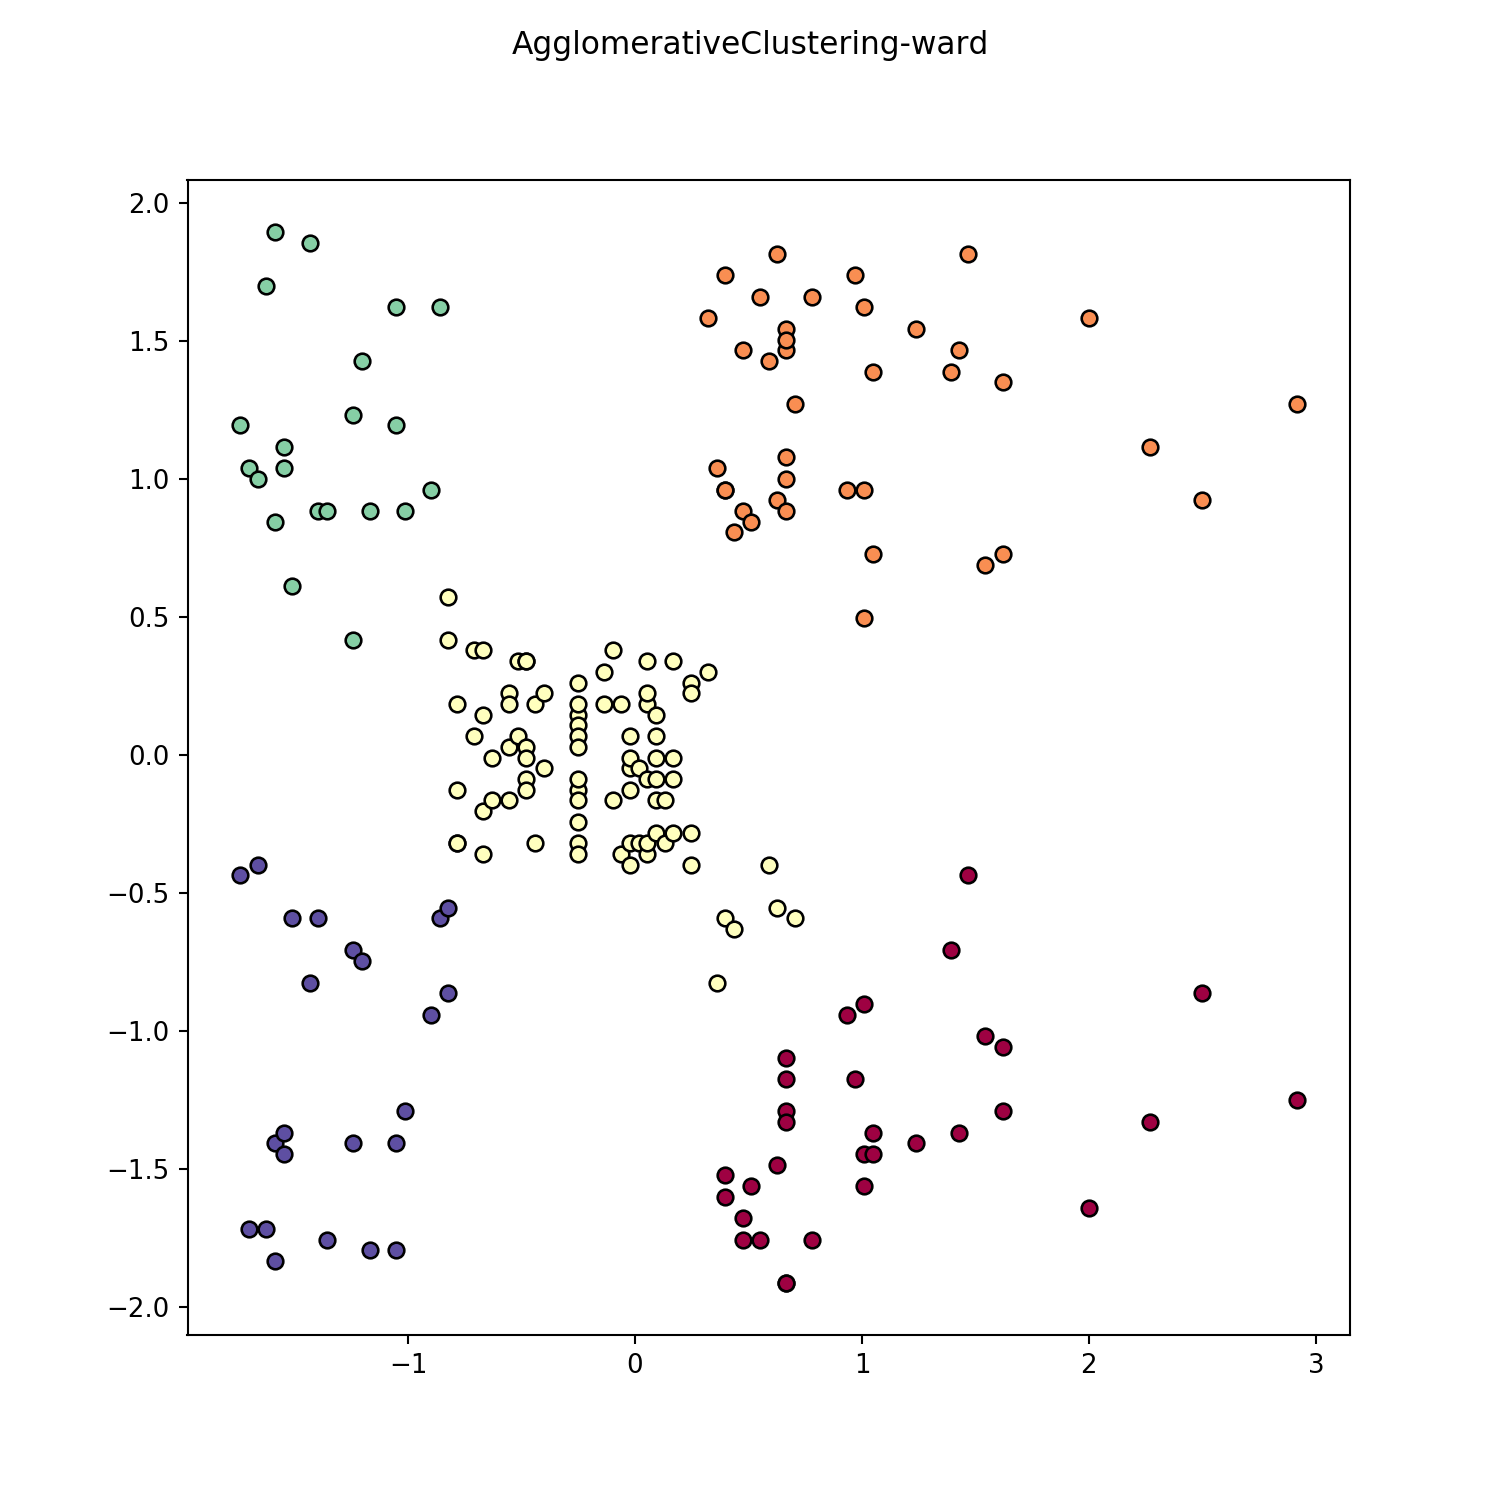

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-average ---------------------
Davies-Bouldin index (lower->better) : 0.6432512549143868
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.479
Calinski-Harabasz score (higher->better): 143.589
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


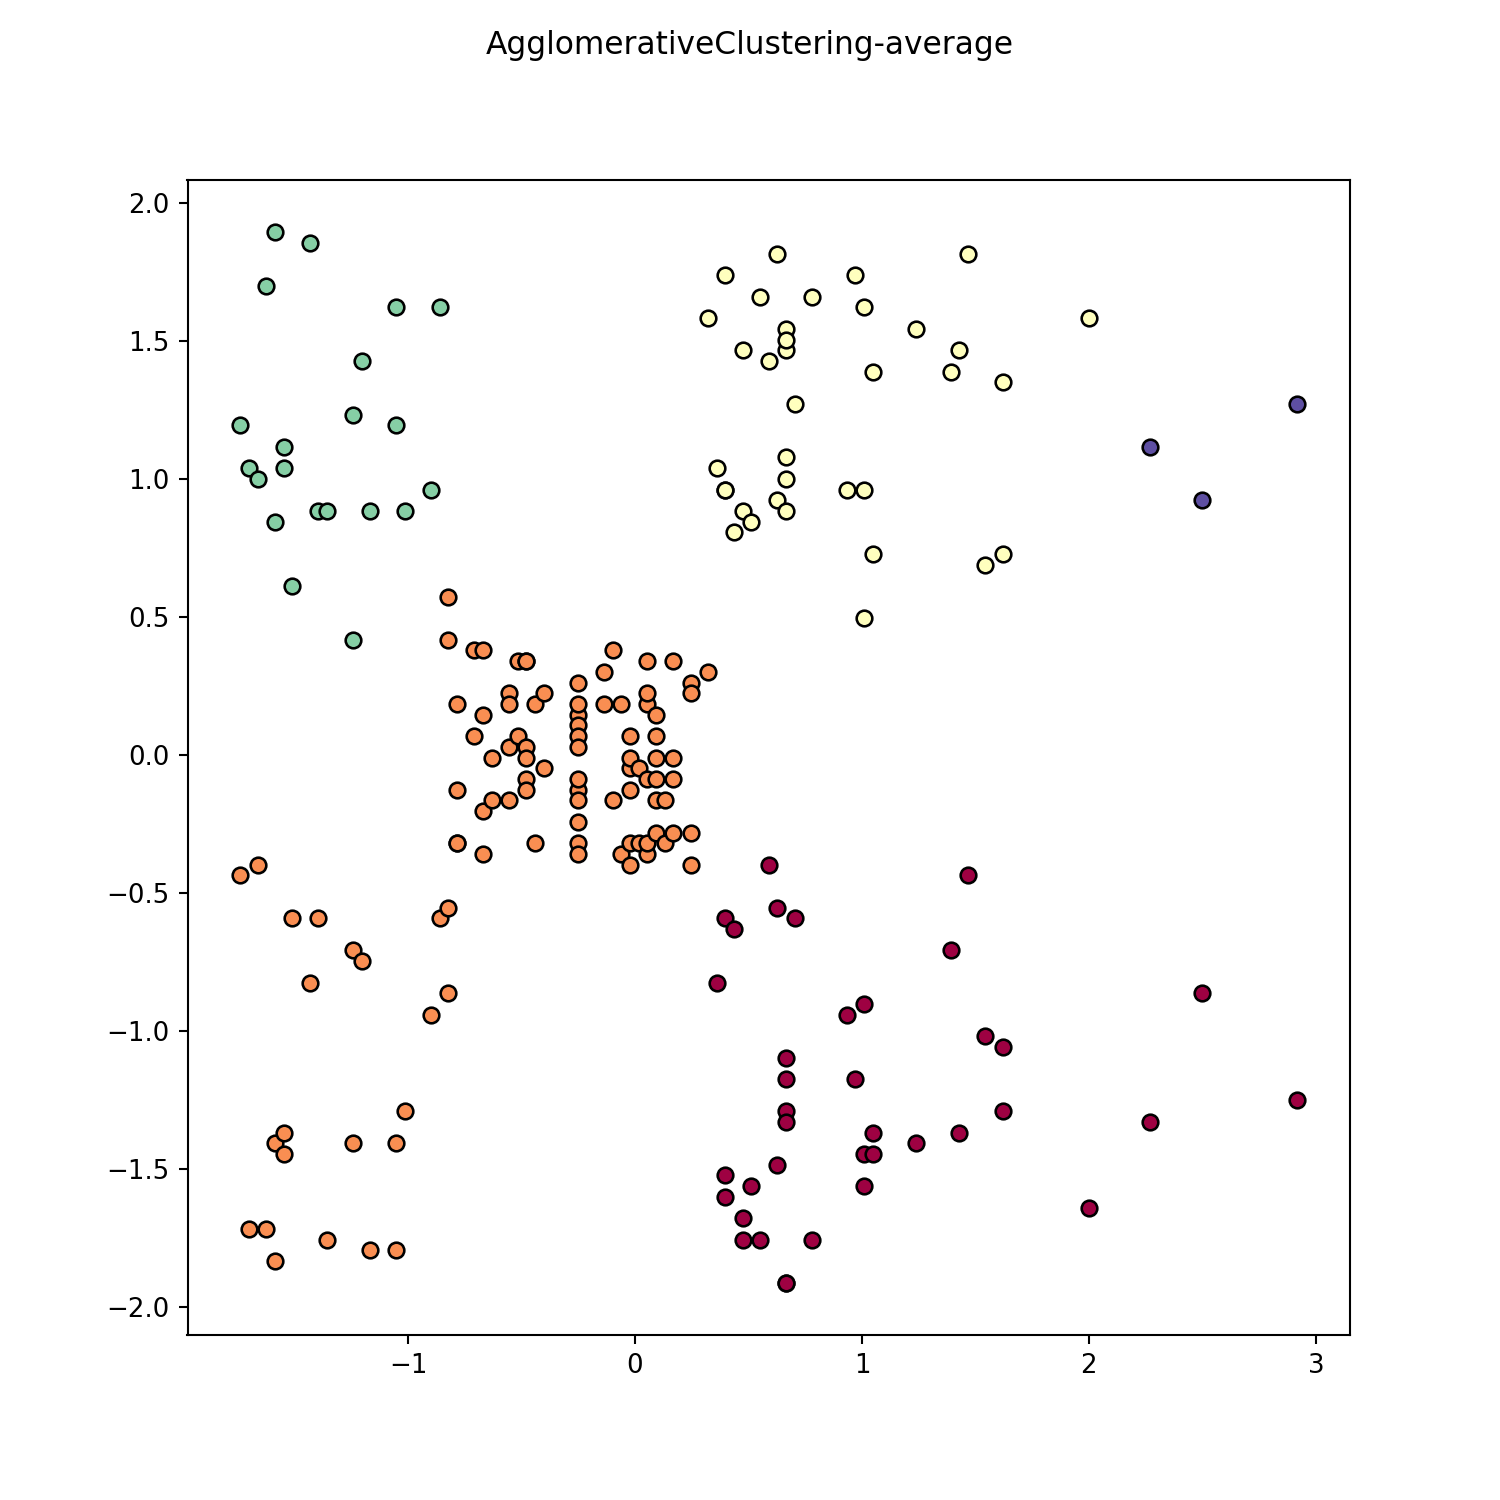

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-complete ---------------------
Davies-Bouldin index (lower->better) : 0.5680153557656494
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.553
Calinski-Harabasz score (higher->better): 247.208
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


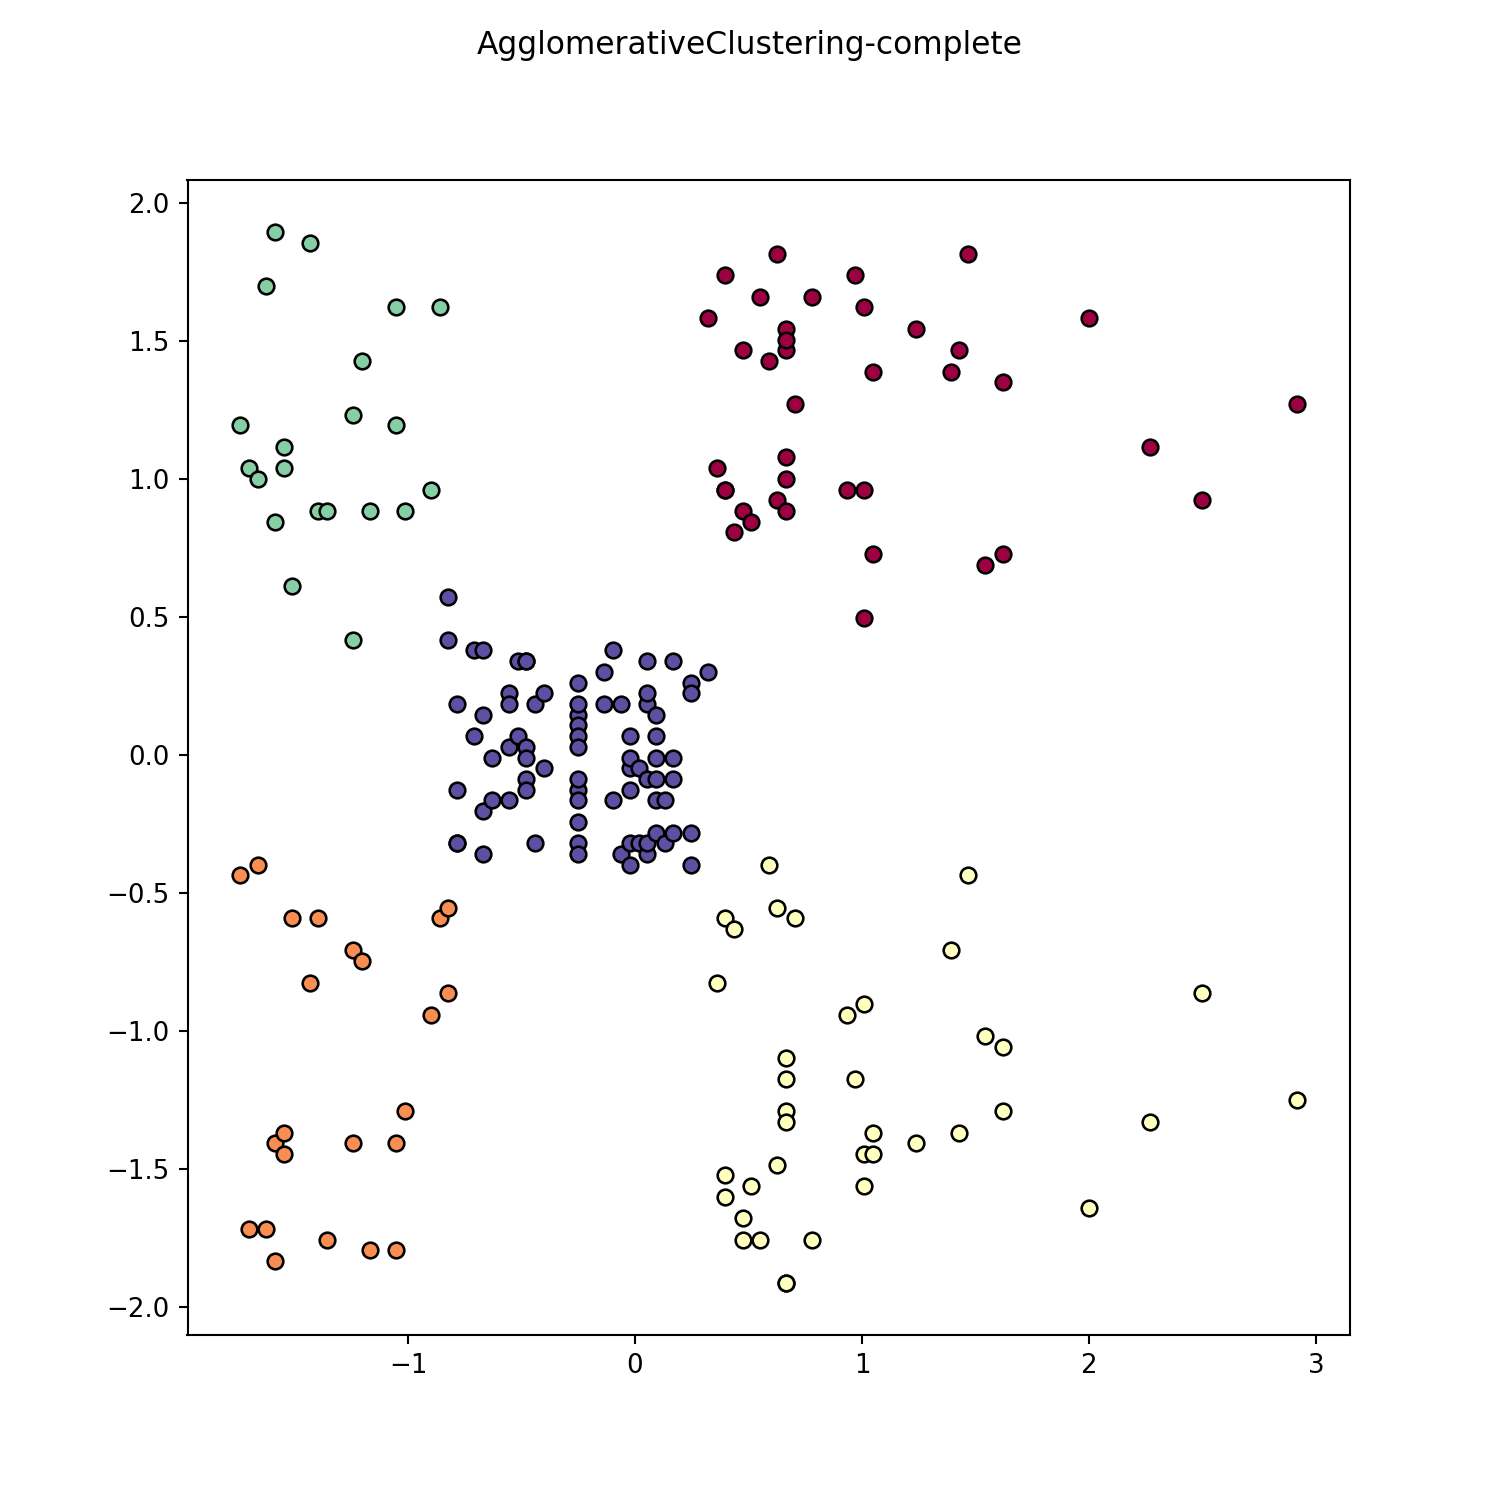

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-single ---------------------
Davies-Bouldin index (lower->better) : 0.4230638761058835
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.276
Calinski-Harabasz score (higher->better): 5.647
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


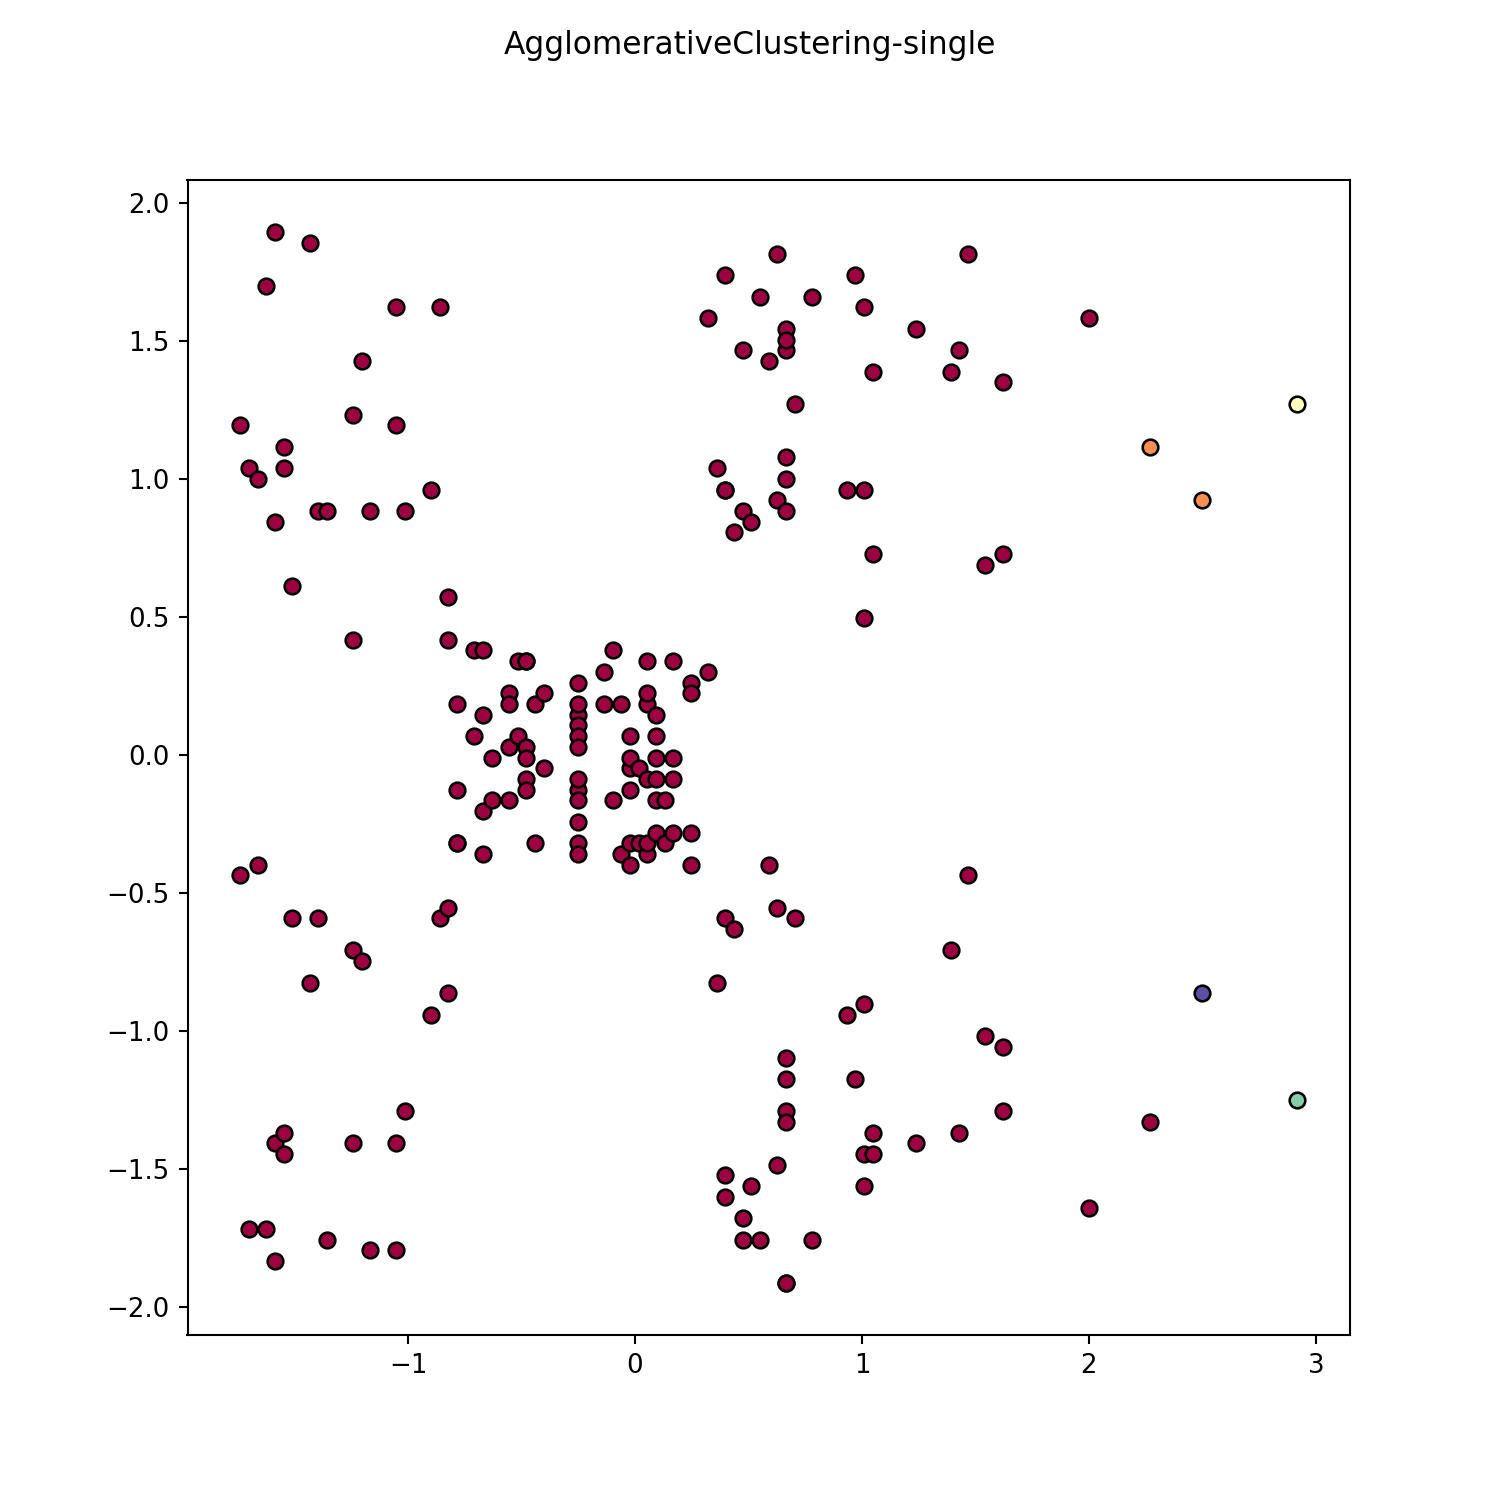

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-full ---------------------
Davies-Bouldin index (lower->better) : 0.5760100302410824
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.554
Calinski-Harabasz score (higher->better): 244.940
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


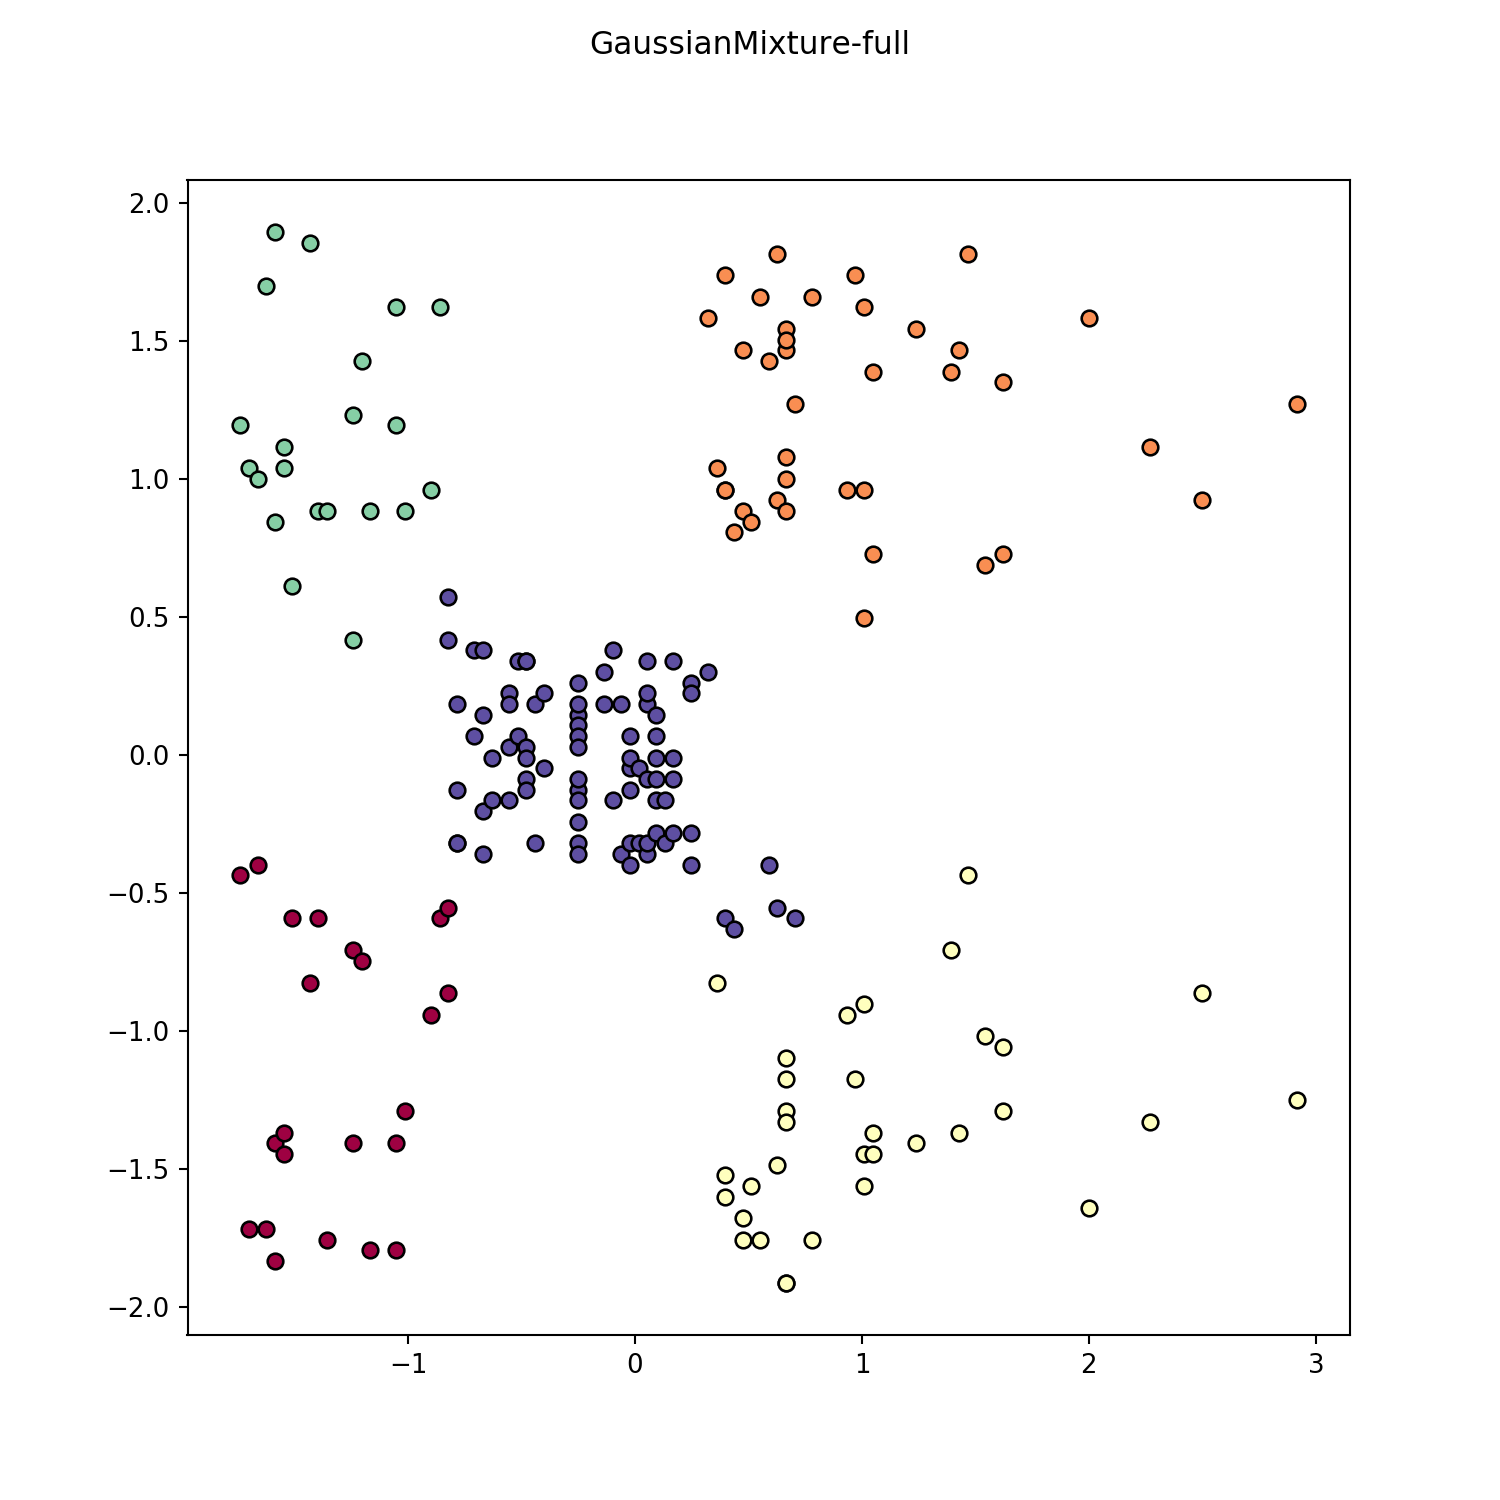

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-tied ---------------------
Davies-Bouldin index (lower->better) : 0.5716358287700496
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.552
Calinski-Harabasz score (higher->better): 240.925
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


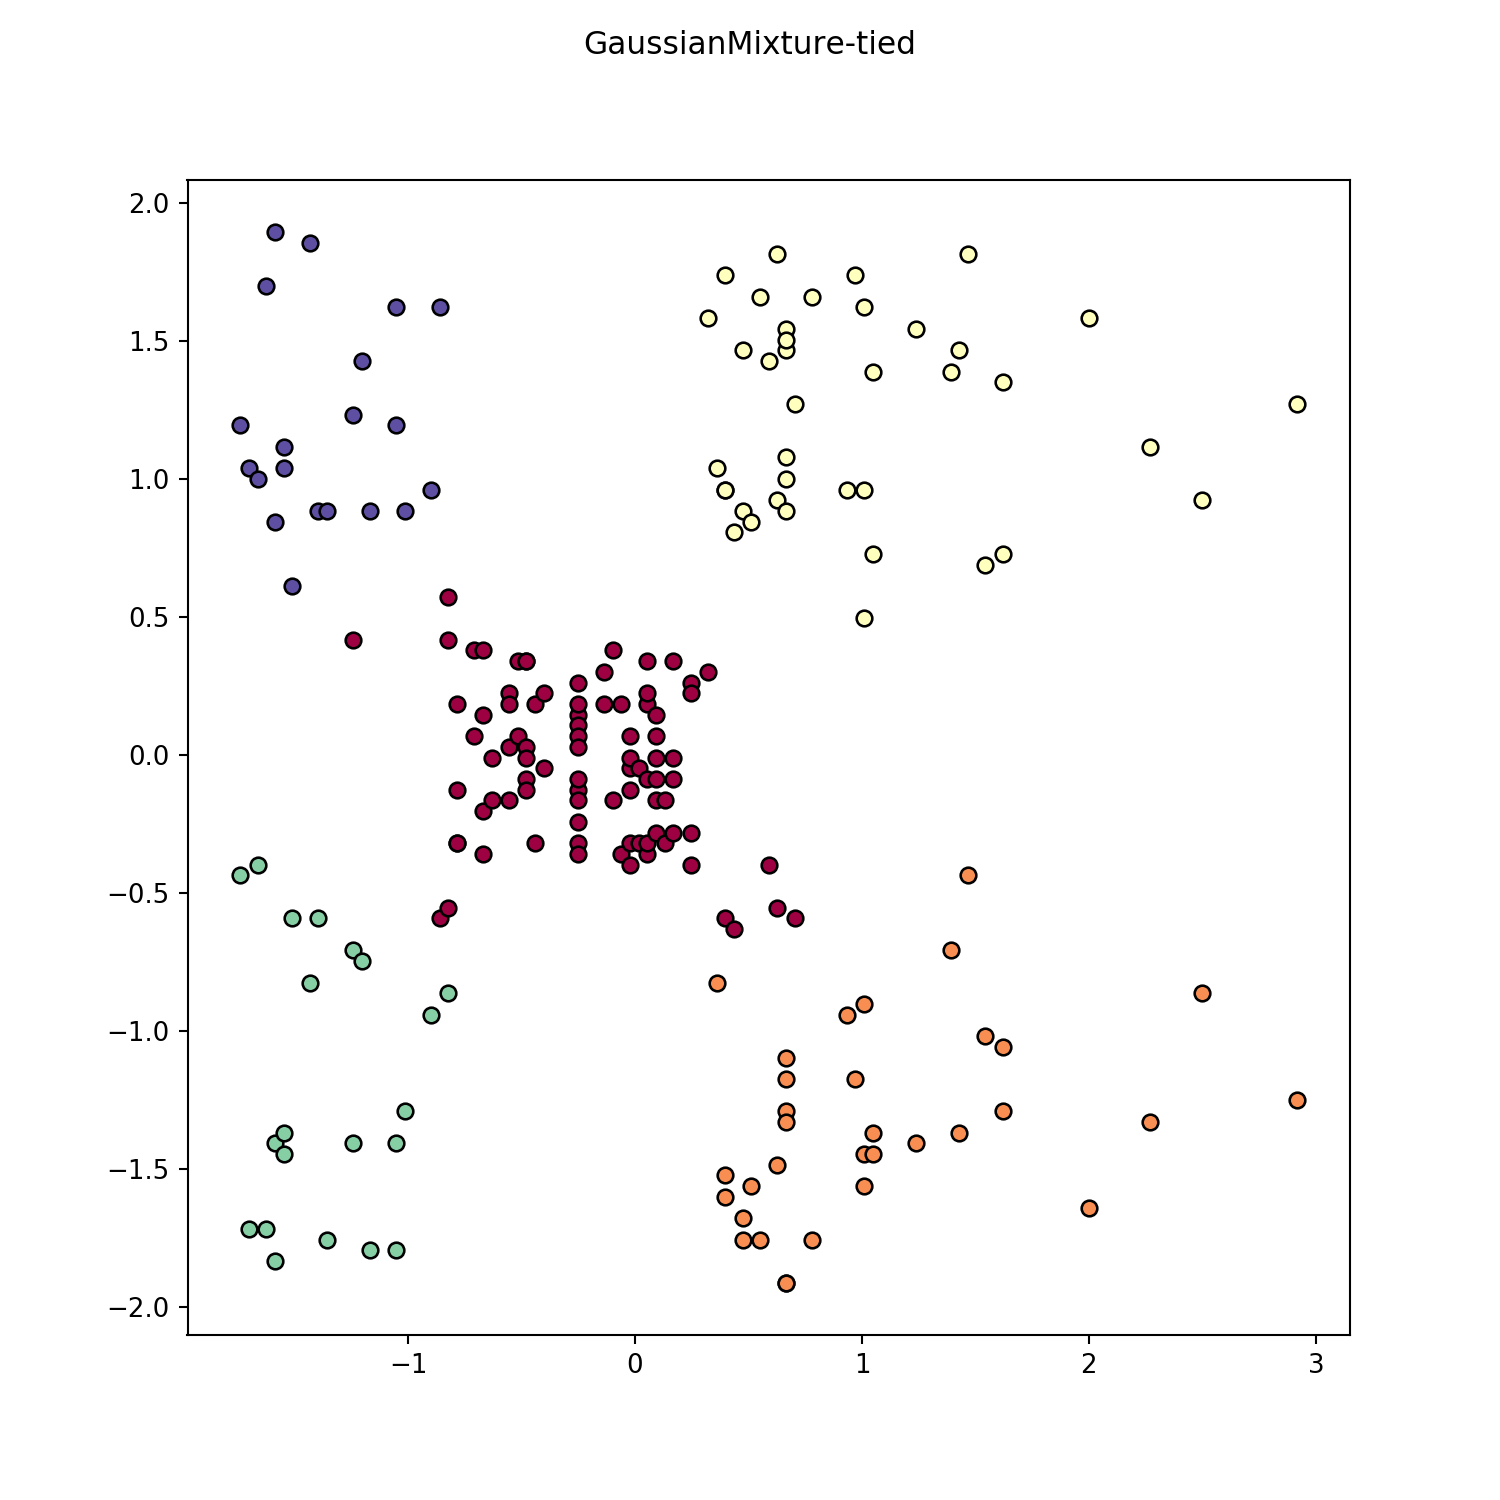

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-diag ---------------------
Davies-Bouldin index (lower->better) : 1.0346168294513474
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.433
Calinski-Harabasz score (higher->better): 123.769
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


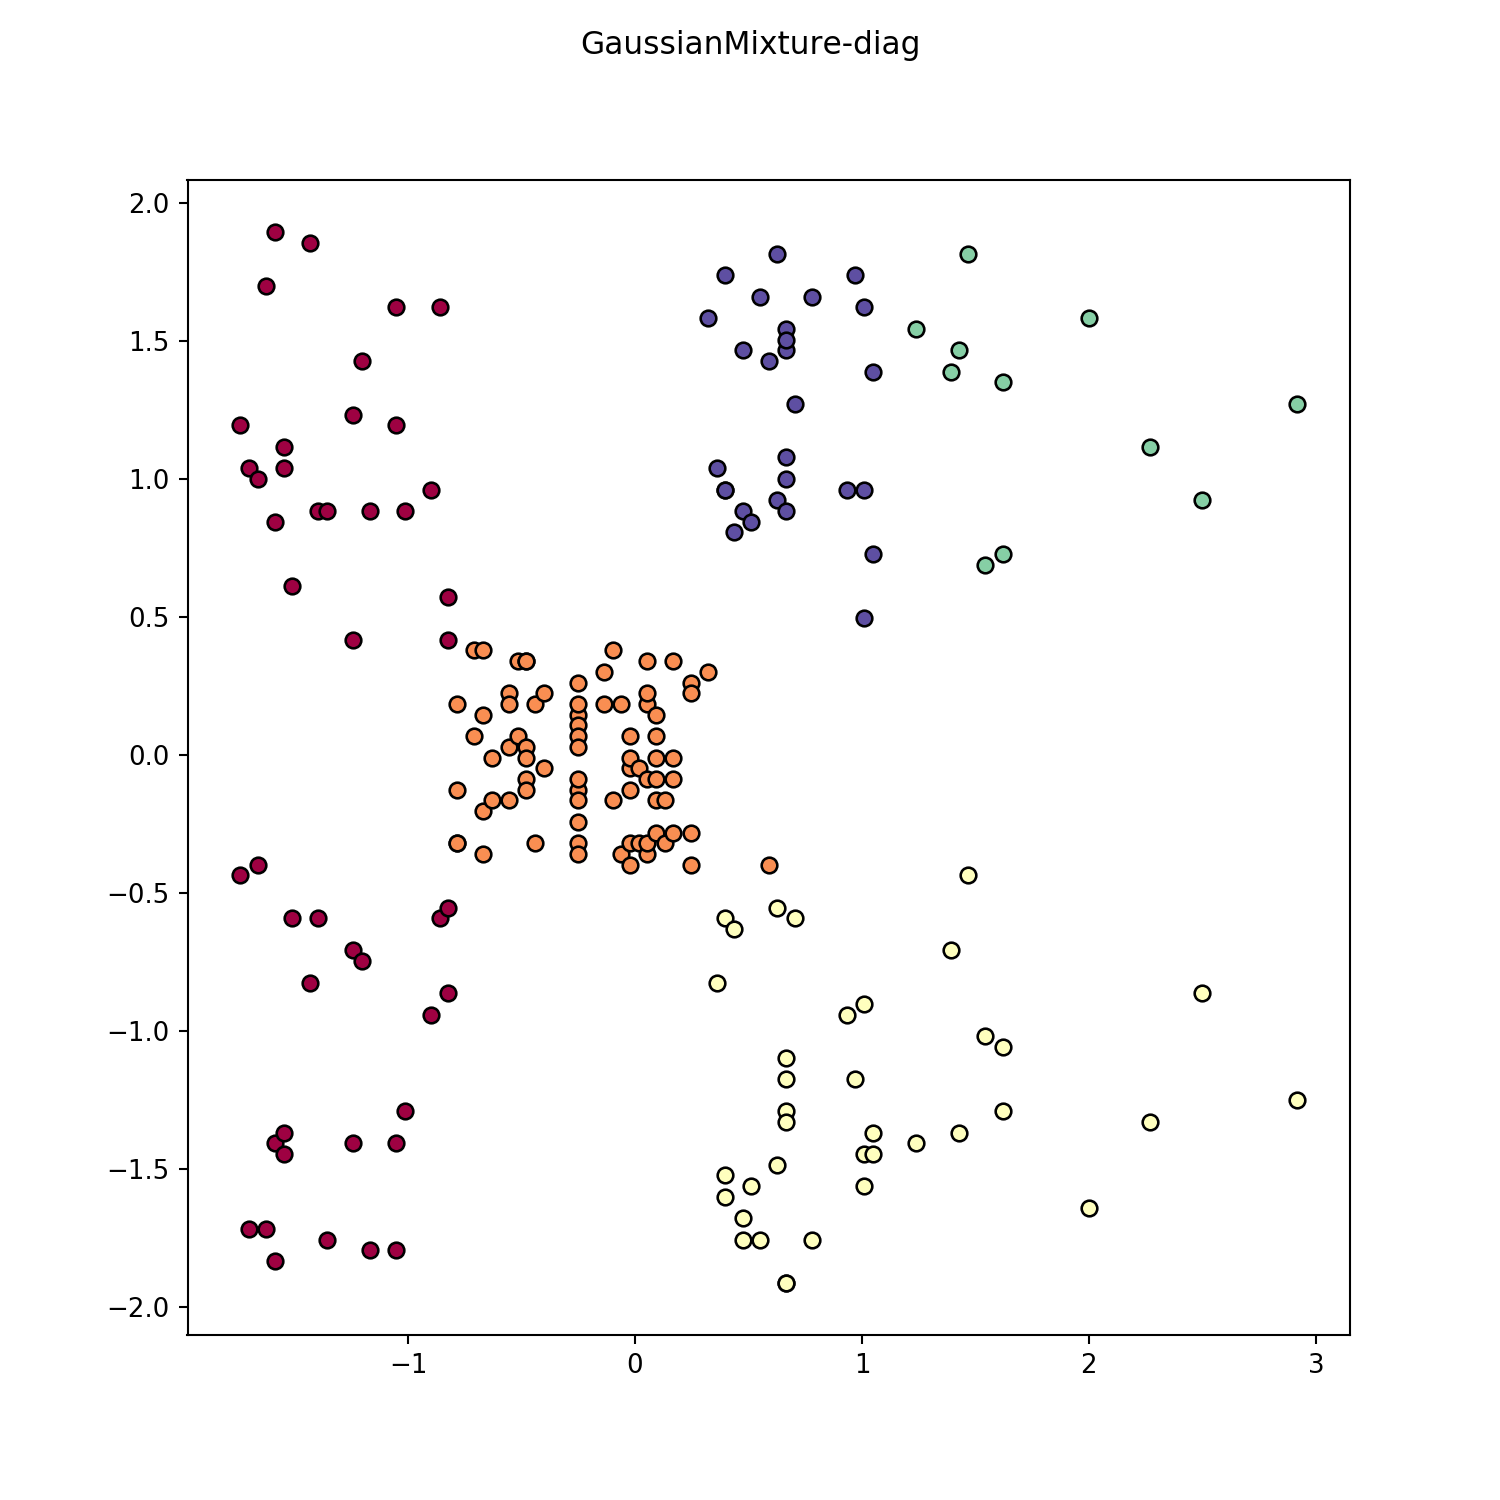

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-spherical ---------------------
Davies-Bouldin index (lower->better) : 0.6891701849215565
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.460
Calinski-Harabasz score (higher->better): 142.180
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


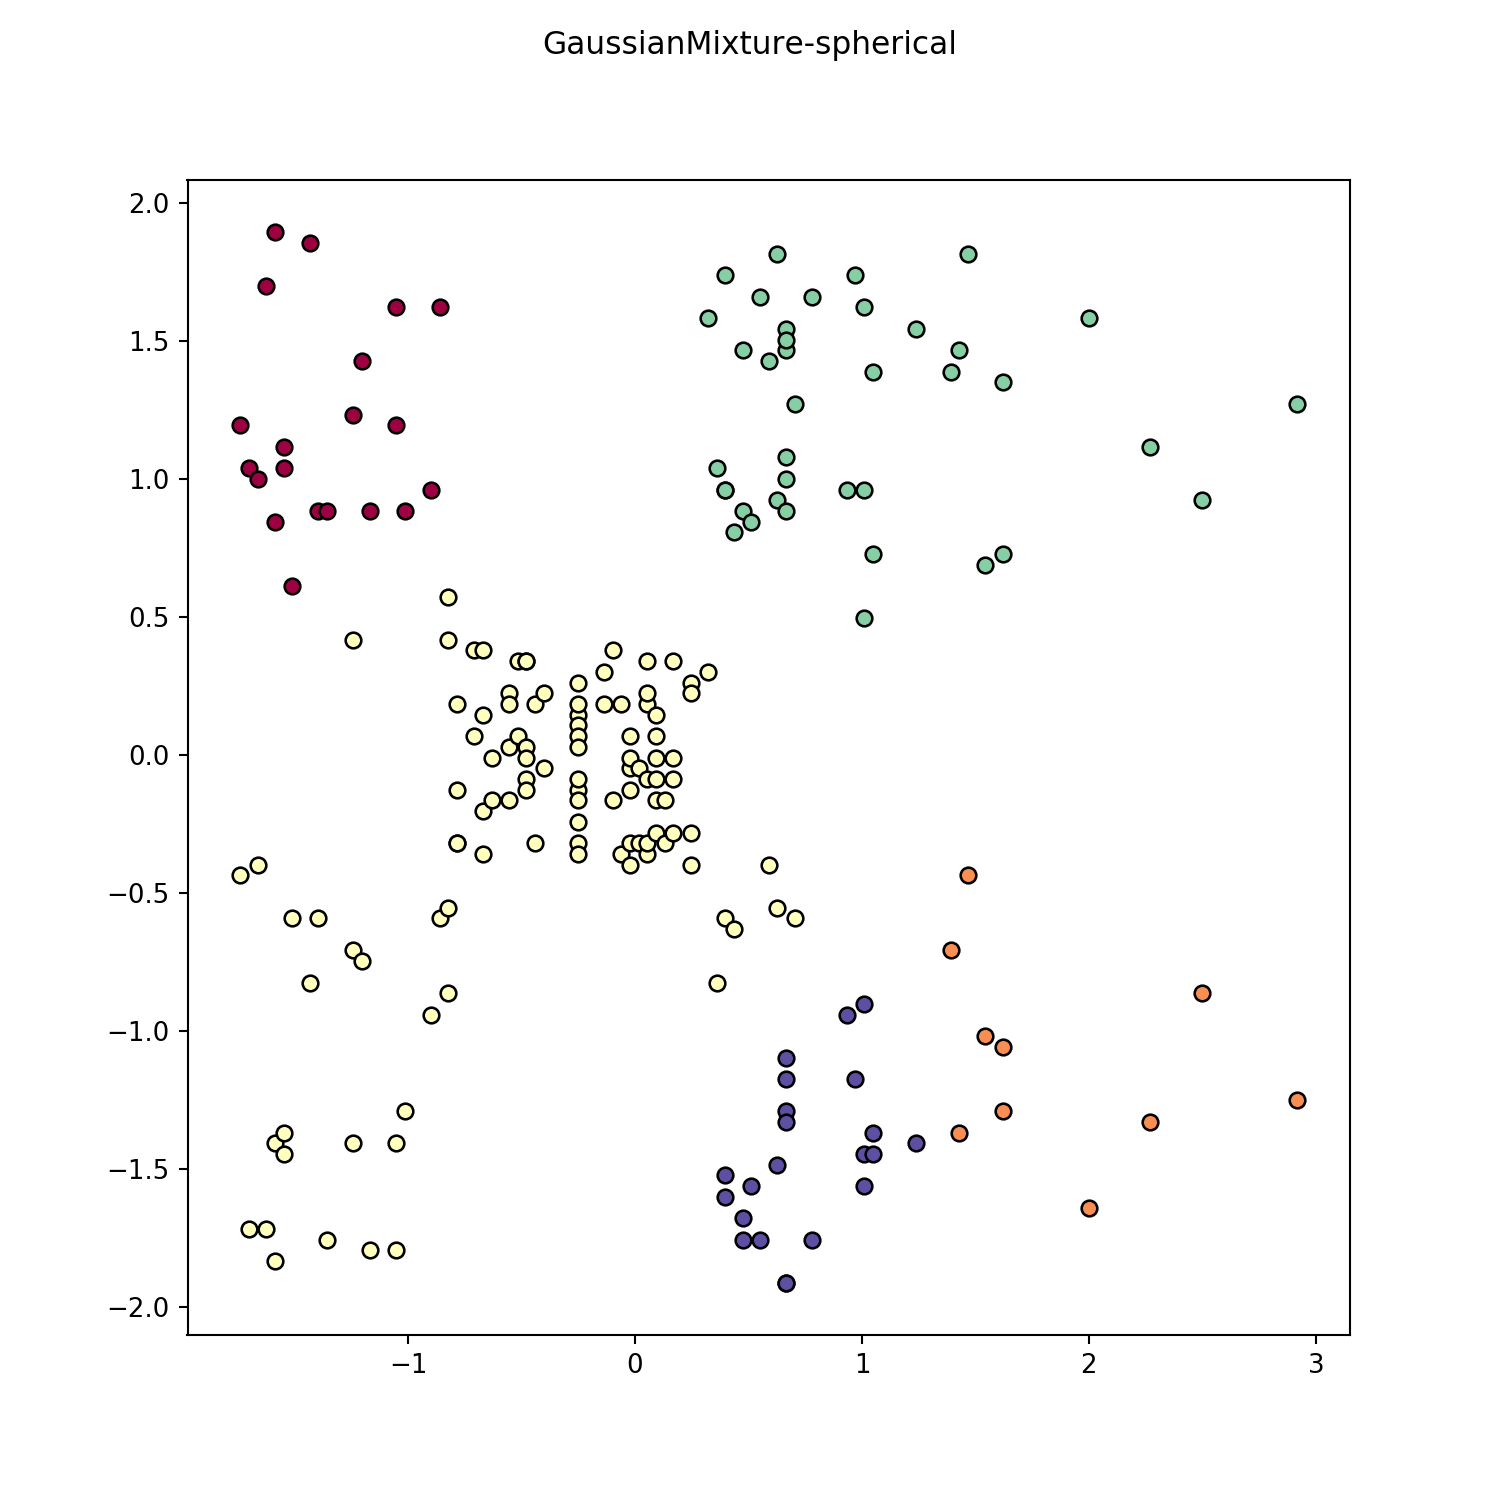

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: DBSCAN ---------------------
Davies-Bouldin index (lower->better) : 1.4193928550582255
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.422
Calinski-Harabasz score (higher->better): 78.924
n_clusters_: 5
n_noise_: 23


<IPython.core.display.Javascript object>


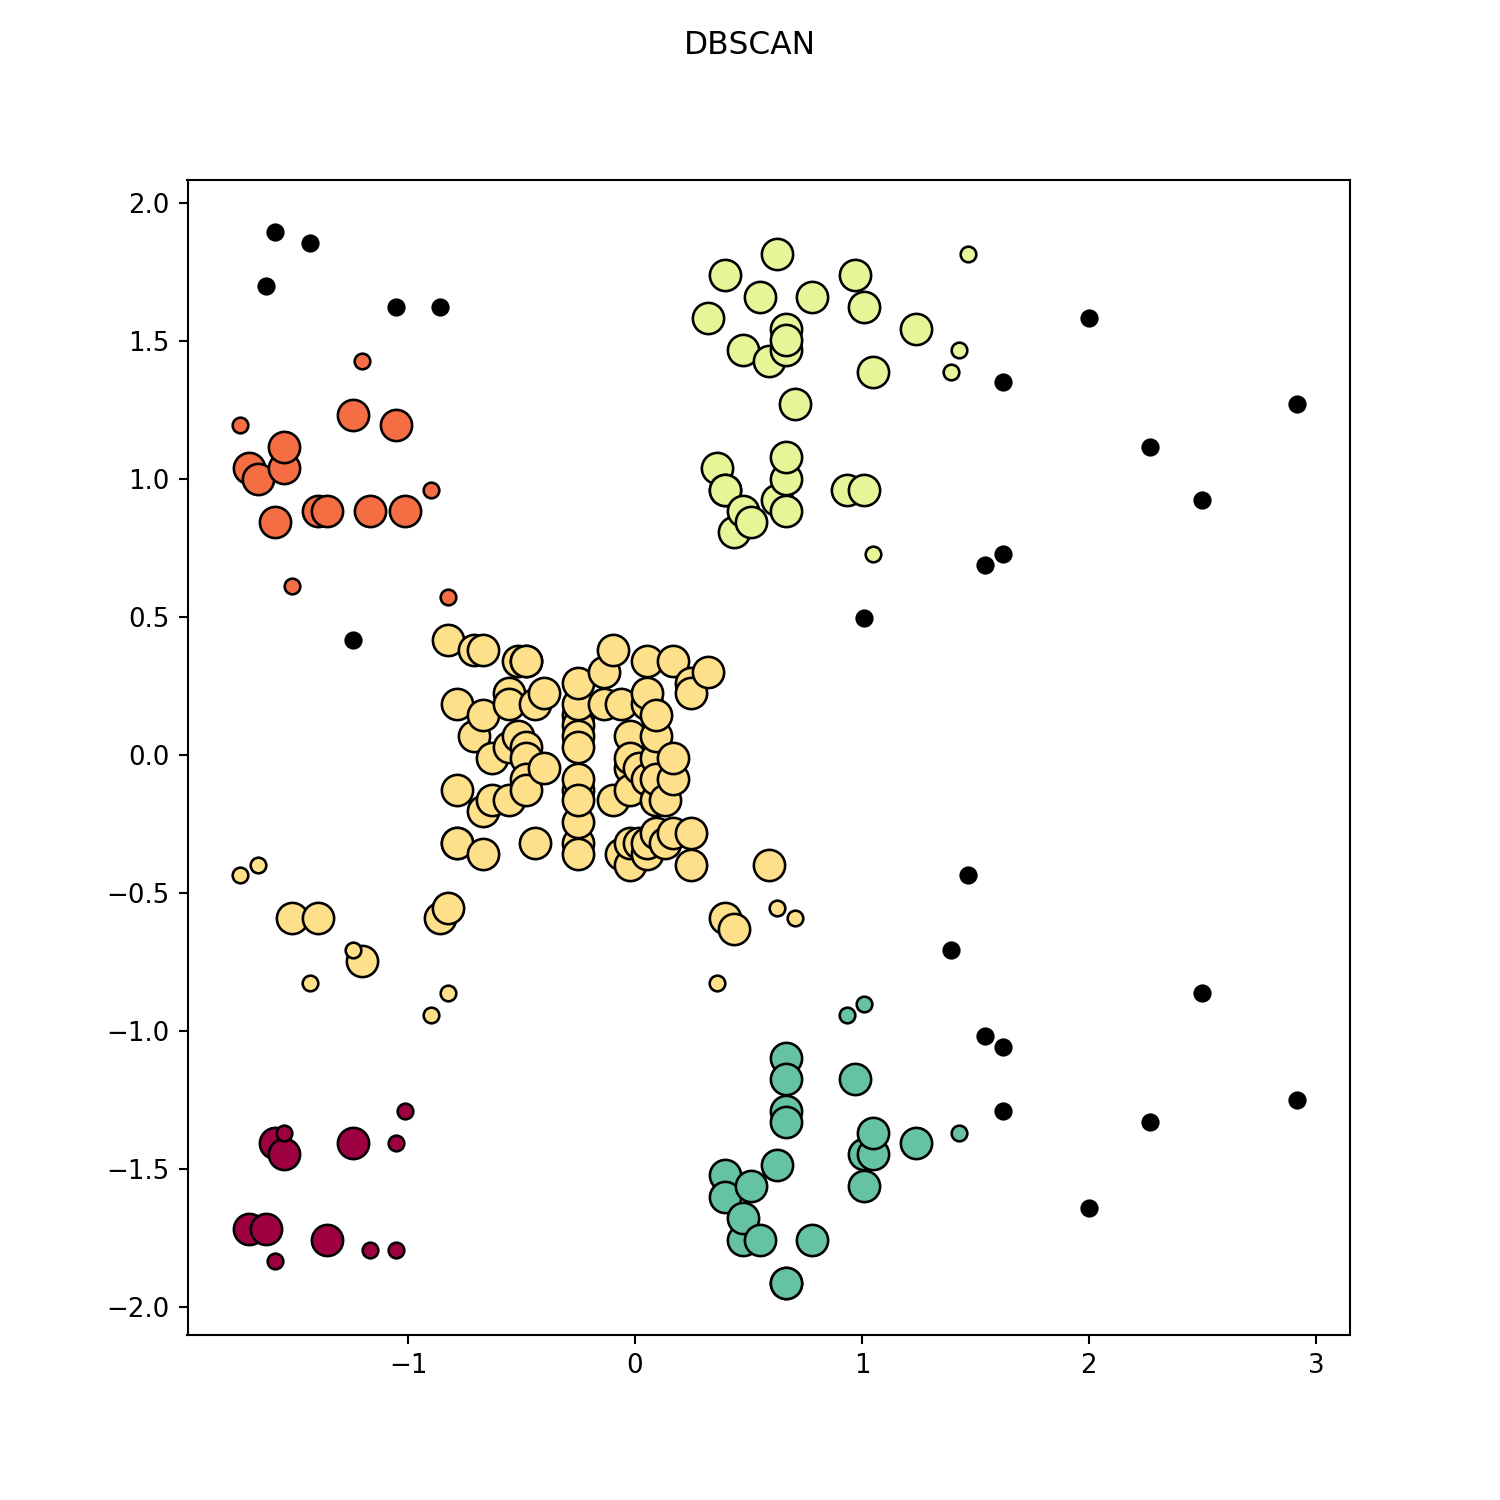

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: OPTICS ---------------------
Davies-Bouldin index (lower->better) : 2.3370105117663806
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.272
Calinski-Harabasz score (higher->better): 29.666
n_clusters_: 5
n_noise_: 57


<IPython.core.display.Javascript object>


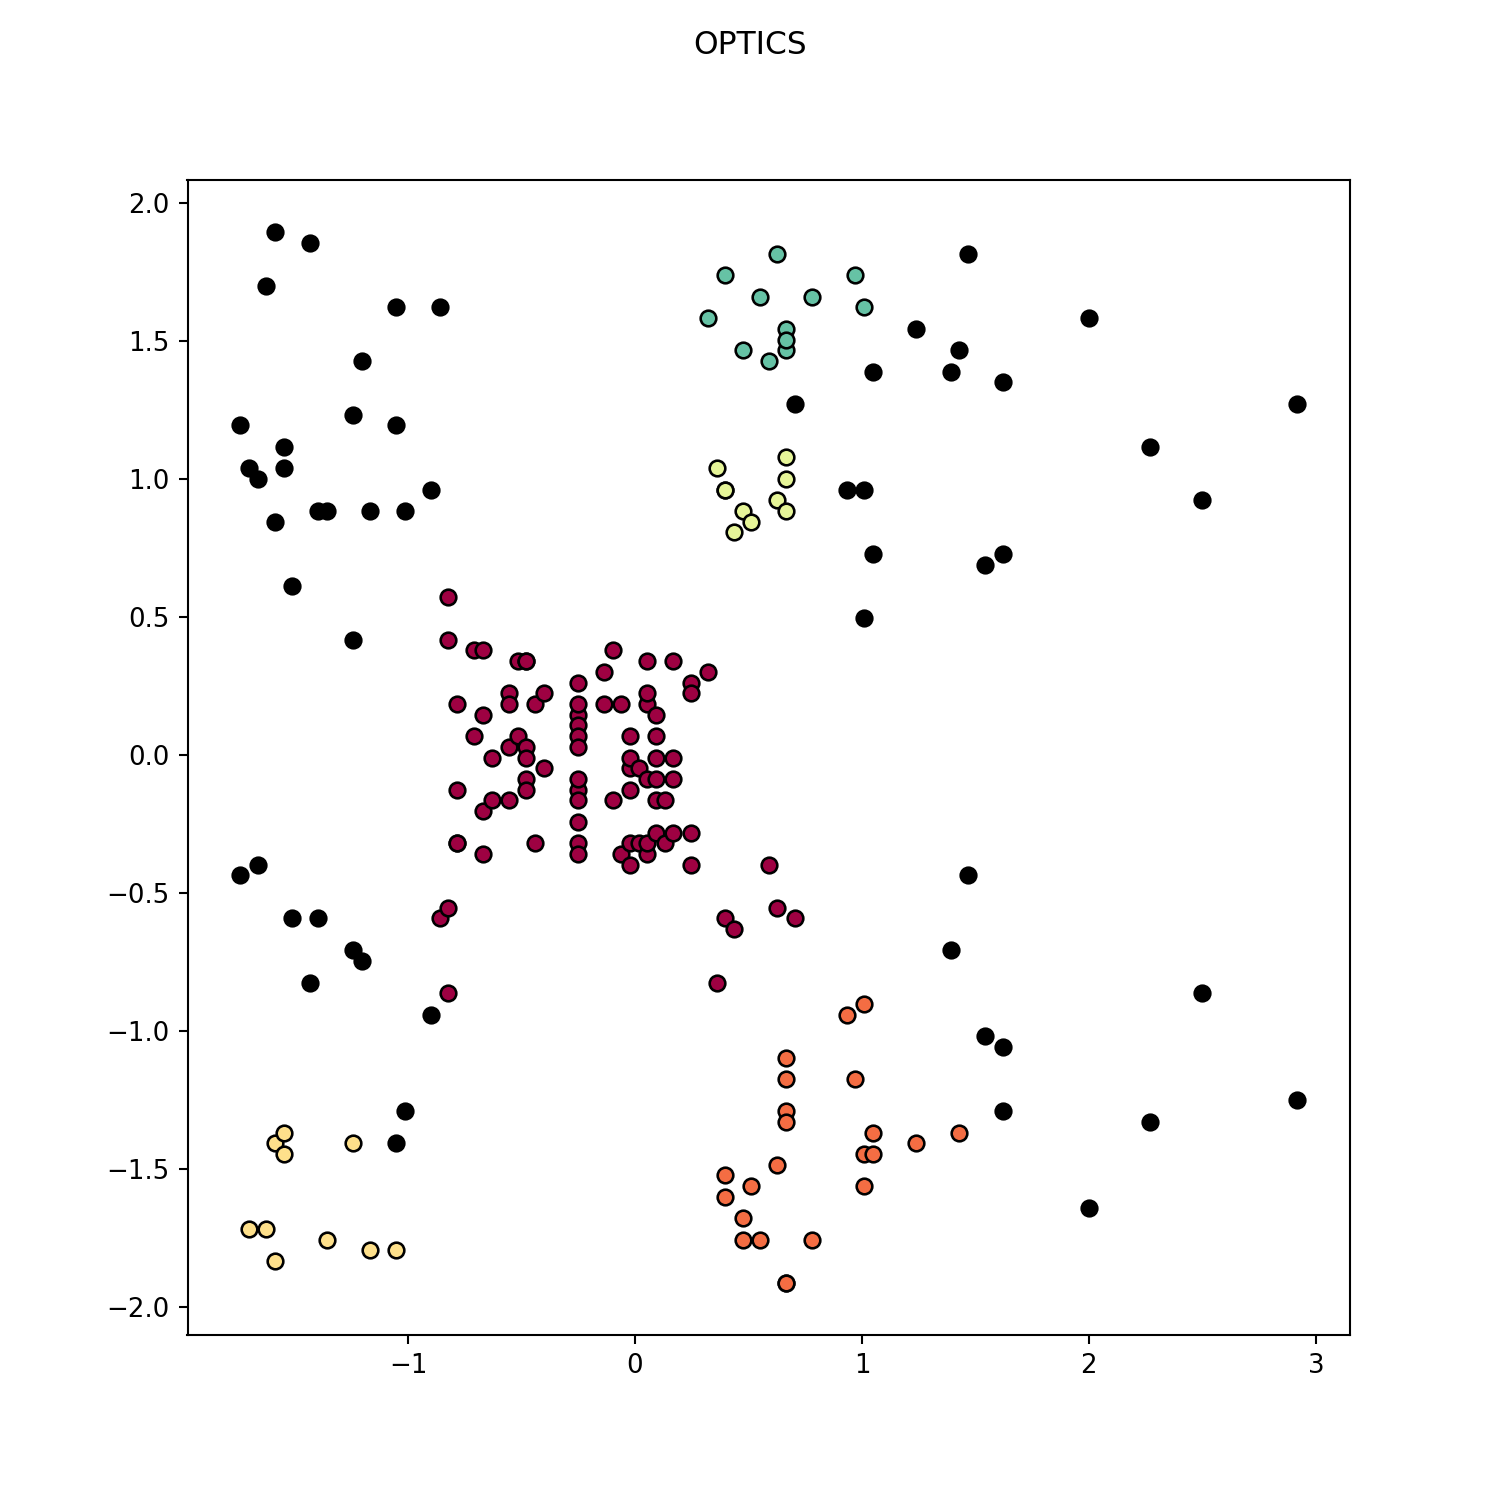

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: KMeans ---------------------
Davies-Bouldin index (lower->better) : 0.5722356162263352
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.555
Calinski-Harabasz score (higher->better): 248.649
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


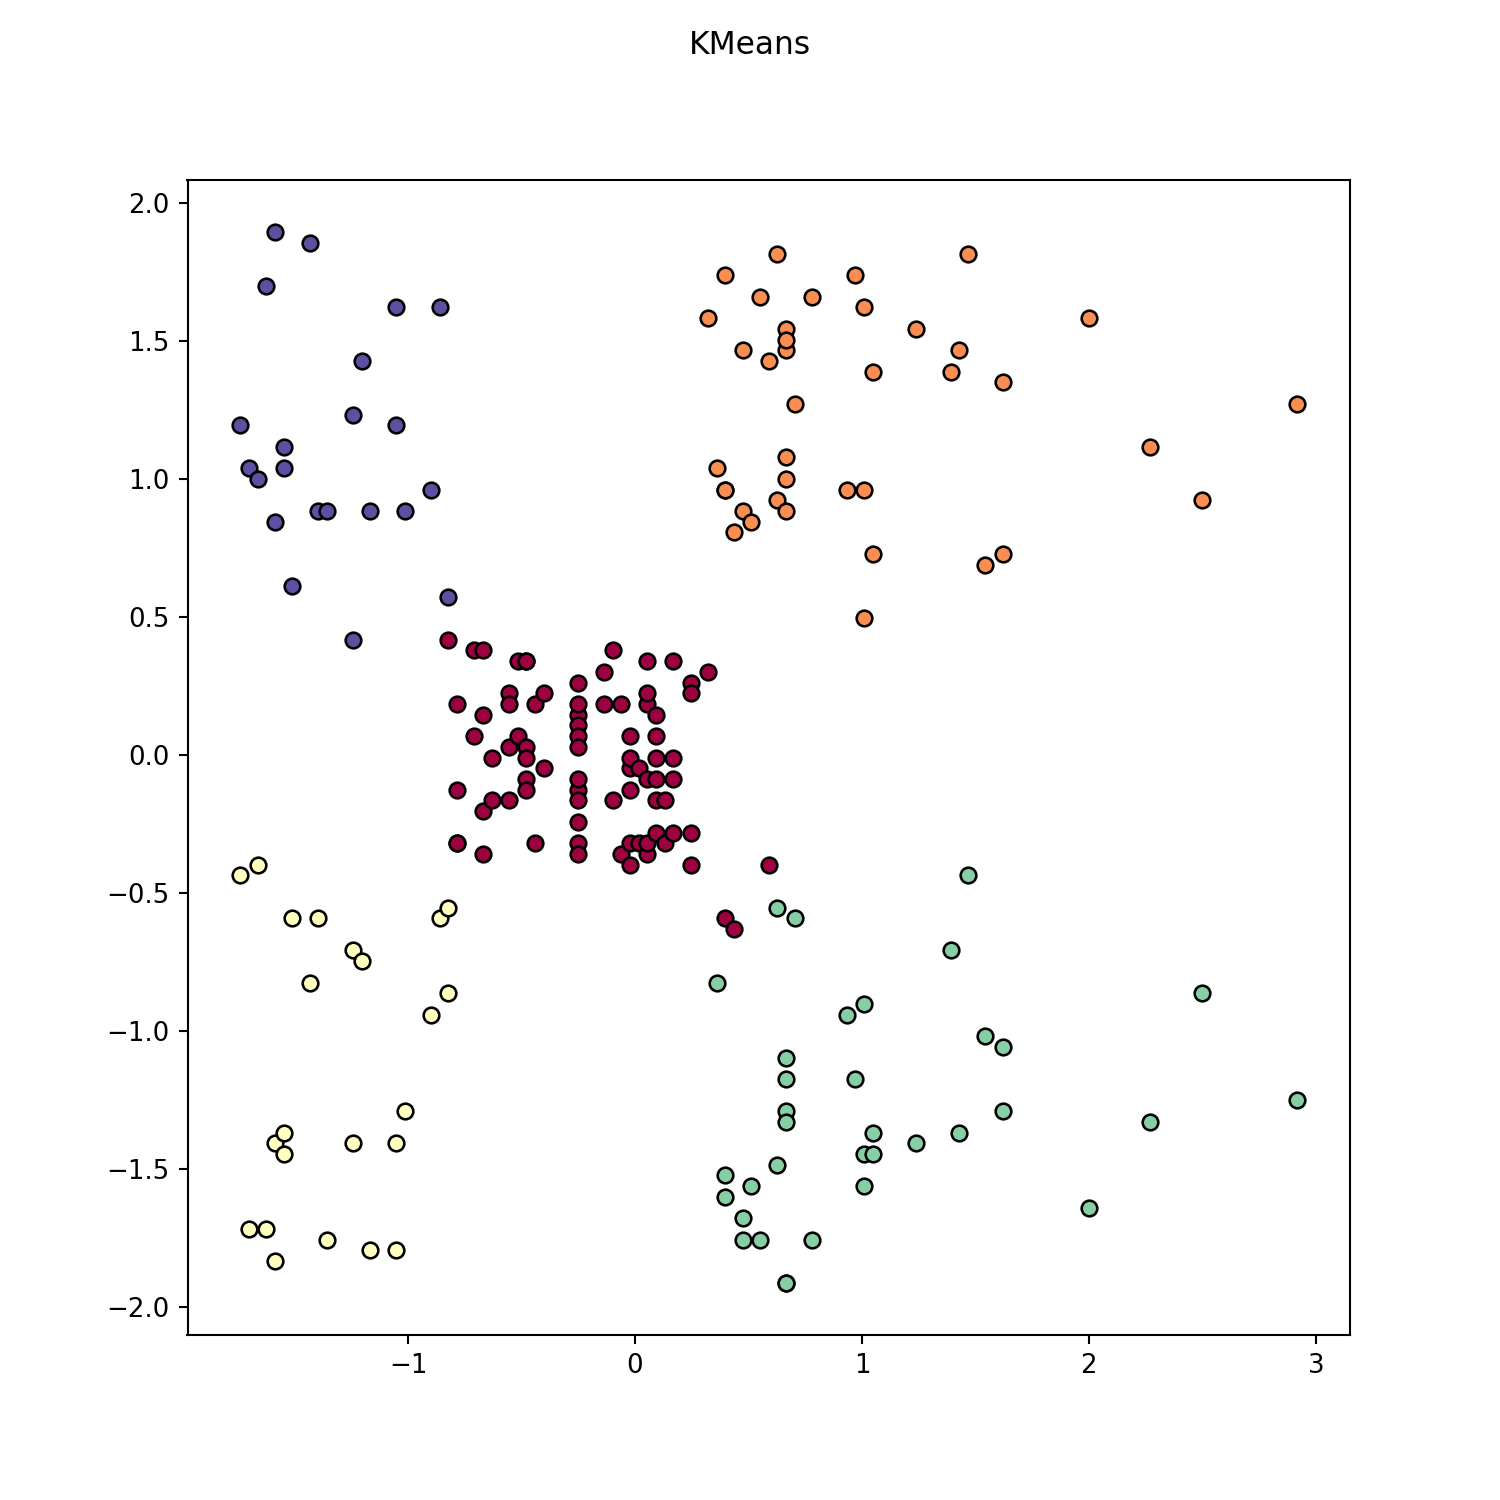

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: FCM ---------------------
Davies-Bouldin index (lower->better) : 0.5722356162263352
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.555
Calinski-Harabasz score (higher->better): 248.649
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


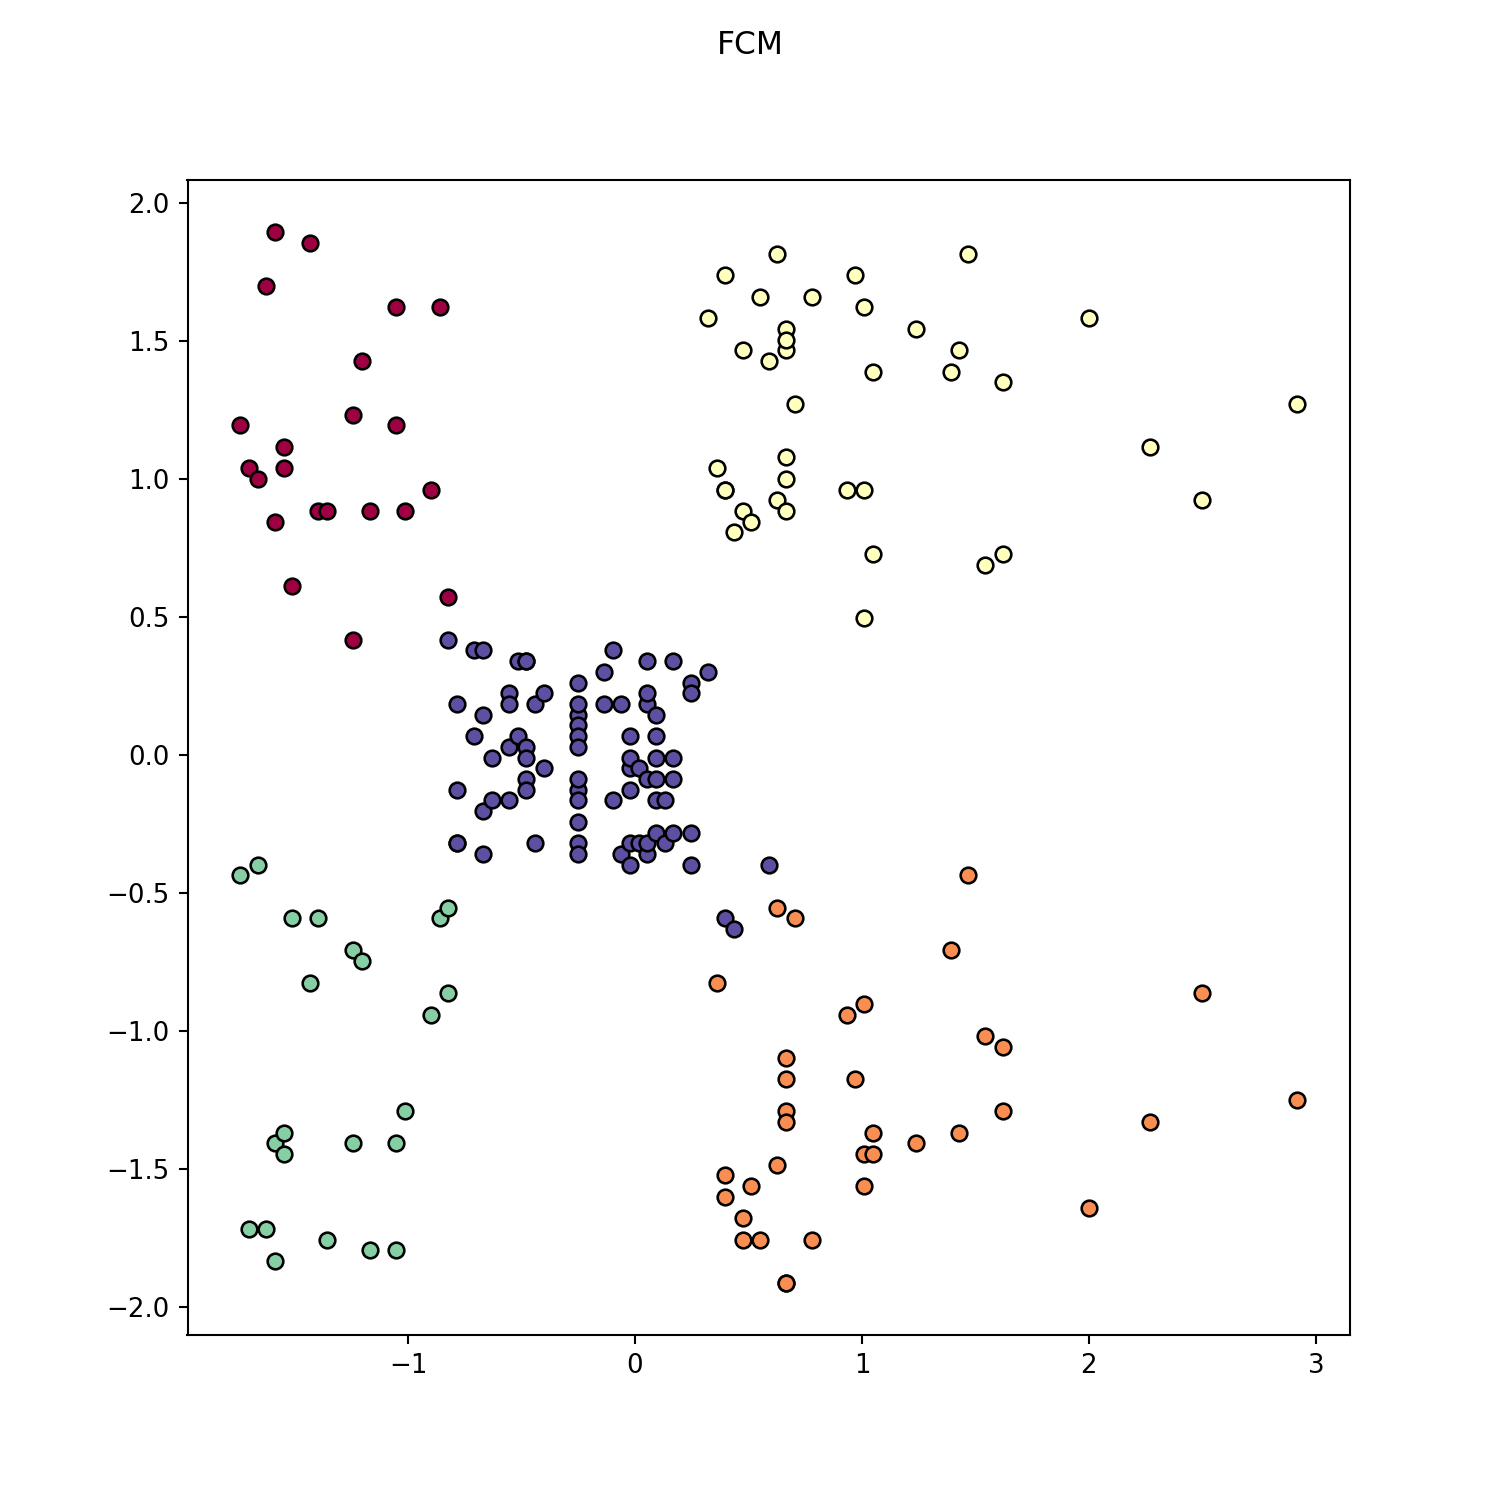

In [183]:
json_config ="""
{
    "dataSourceUrl": "/home/jovyan/host-note/data/Mall_Customers.csv",
    "dataDelimiter": ",",
    "n_clusters": 5,
    "eps": 0.38 ,
    "min_samples": 6,
    "xi": 0.2,
    "min_cluster_size": 0.05,
    "m": 2,
    "ndims": 2
}"""
config = json.loads(json_config, object_hook = as_config)
main(['Inc','SpendScore'])

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10,263,48,44.5
Arizona,8.1,294,80,31
Arkansas,8.8,190,50,19.5
Data set shape: (50, 5)
-------------------------------------------------------------------------------------------
--------------------- Running clustering for: DBSCAN ---------------------
Davies-Bouldin index (lower->better) : 1.8205847175986993
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.183
Calinski-Harabasz score (higher->better): 26.250
n_clusters_: 4
n_noise_: 14


<IPython.core.display.Javascript object>


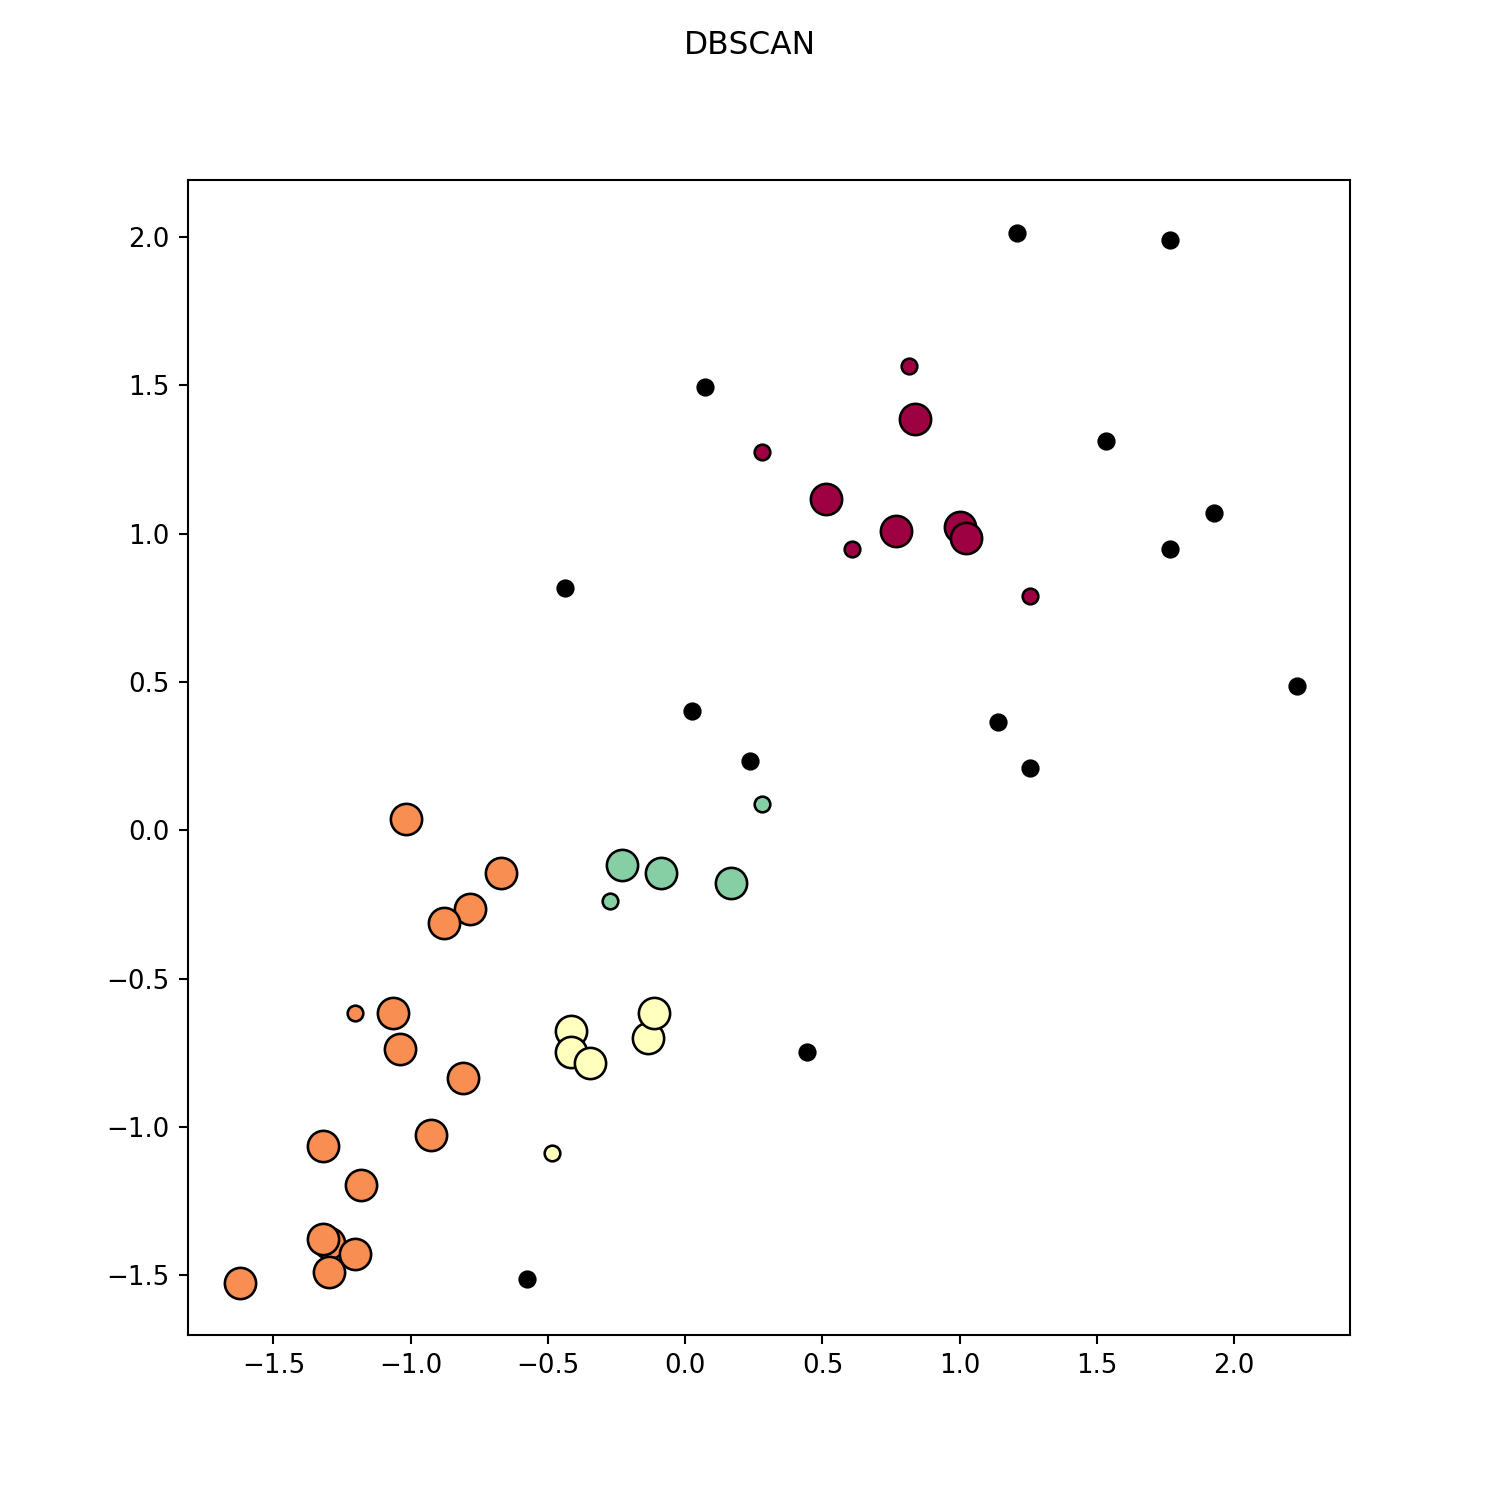

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: OPTICS ---------------------
Davies-Bouldin index (lower->better) : 1.4949937582895505
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.264
Calinski-Harabasz score (higher->better): 34.638
n_clusters_: 5
n_noise_: 12


<IPython.core.display.Javascript object>


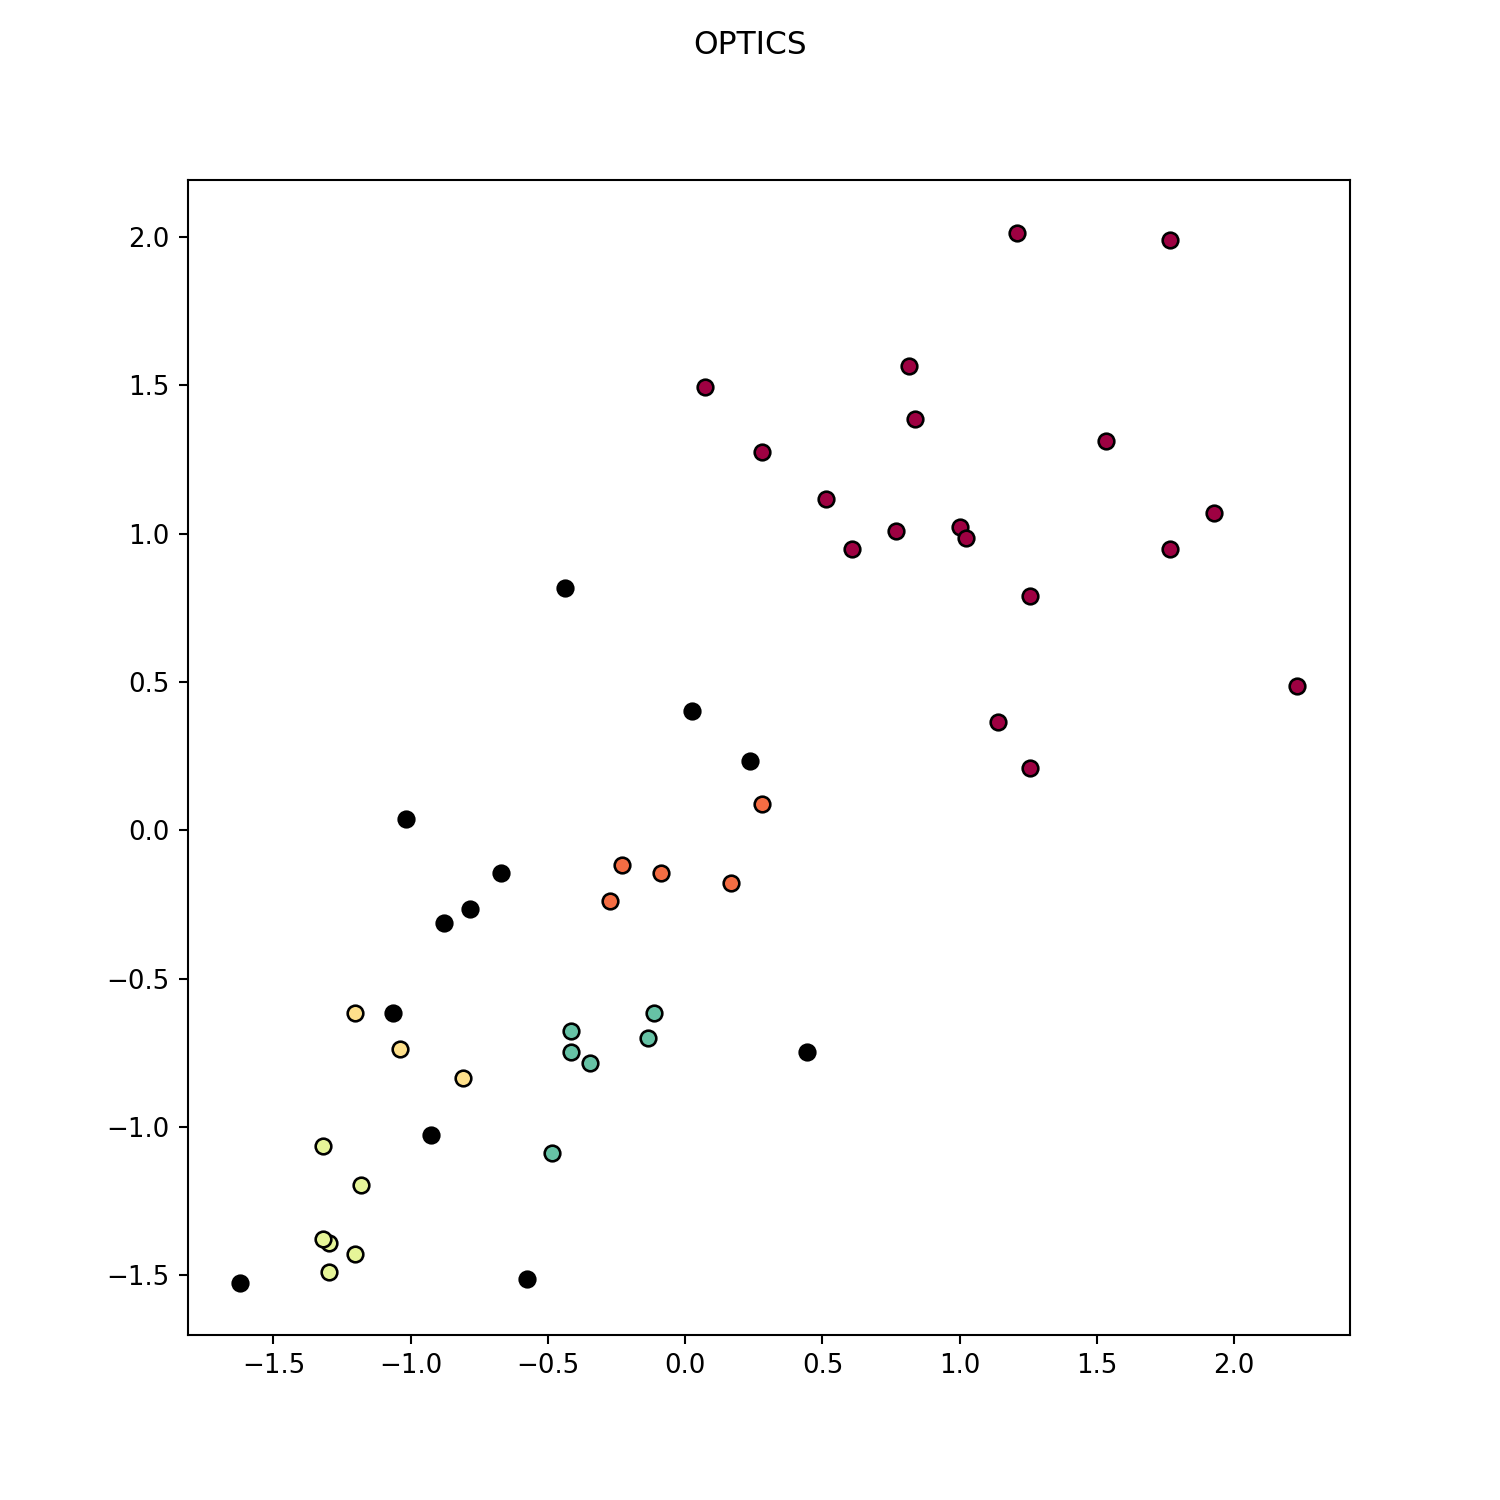

In [147]:
json_config ="""
{
    "dataSourceUrl": "/home/jovyan/host-note/data/USArrests.csv",
    "dataDelimiter": ",",
    "n_clusters": 4,
    "eps": 0.4,
    "min_samples": 4,
    "xi": 0.05,
    "min_cluster_size": 0.06,
    "m": 2,
    "ndims": 2
}"""
config = json.loads(json_config, object_hook = as_config)
main(['Murder','Assault'])

"gender","race/ethnicity","parental level of education","lunch","test preparation course","math score","reading score","writing score"
"female","group B","bachelor's degree","standard","none","72","72","74"
"female","group C","some college","standard","completed","69","90","88"
"female","group B","master's degree","standard","none","90","95","93"
"male","group A","associate's degree","free/reduced","none","47","57","44"
Data set shape: (1000, 8)
-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-ward ---------------------
Davies-Bouldin index (lower->better) : 0.852398427487568
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.324
Calinski-Harabasz score (higher->better): 1123.081
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


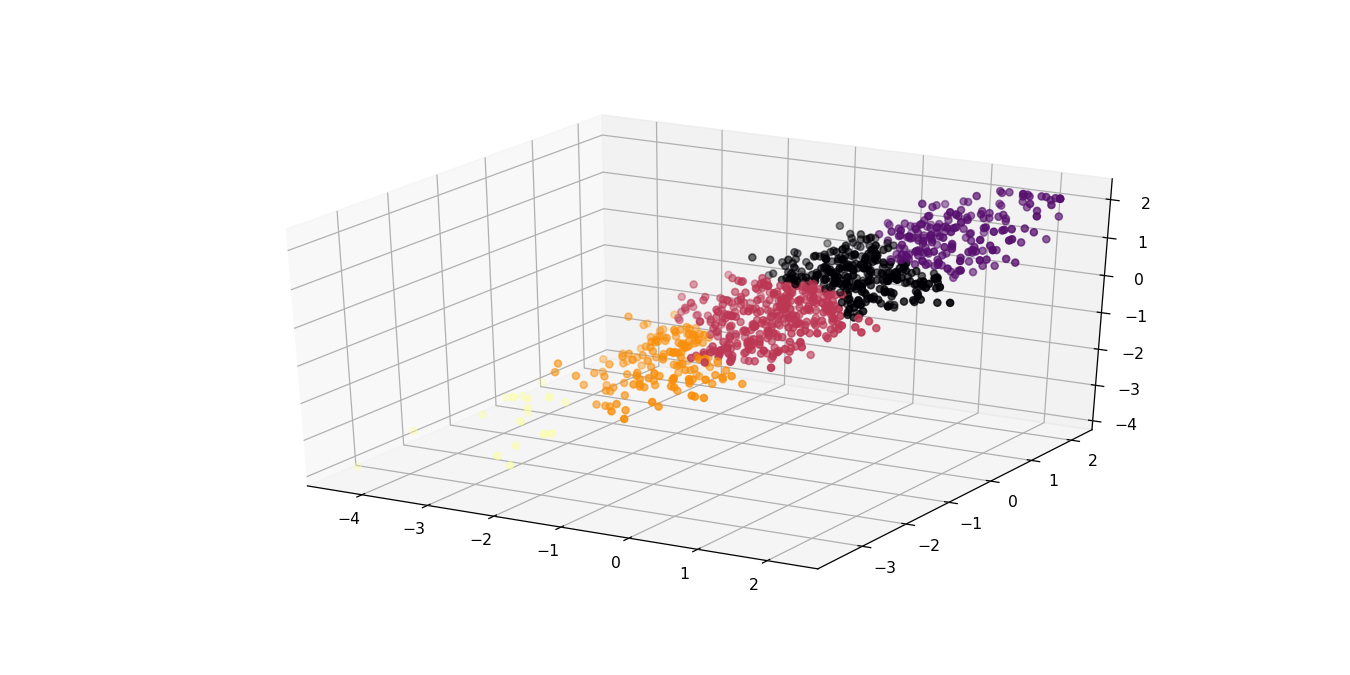

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-average ---------------------
Davies-Bouldin index (lower->better) : 0.7097474601002163
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.363
Calinski-Harabasz score (higher->better): 769.879
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


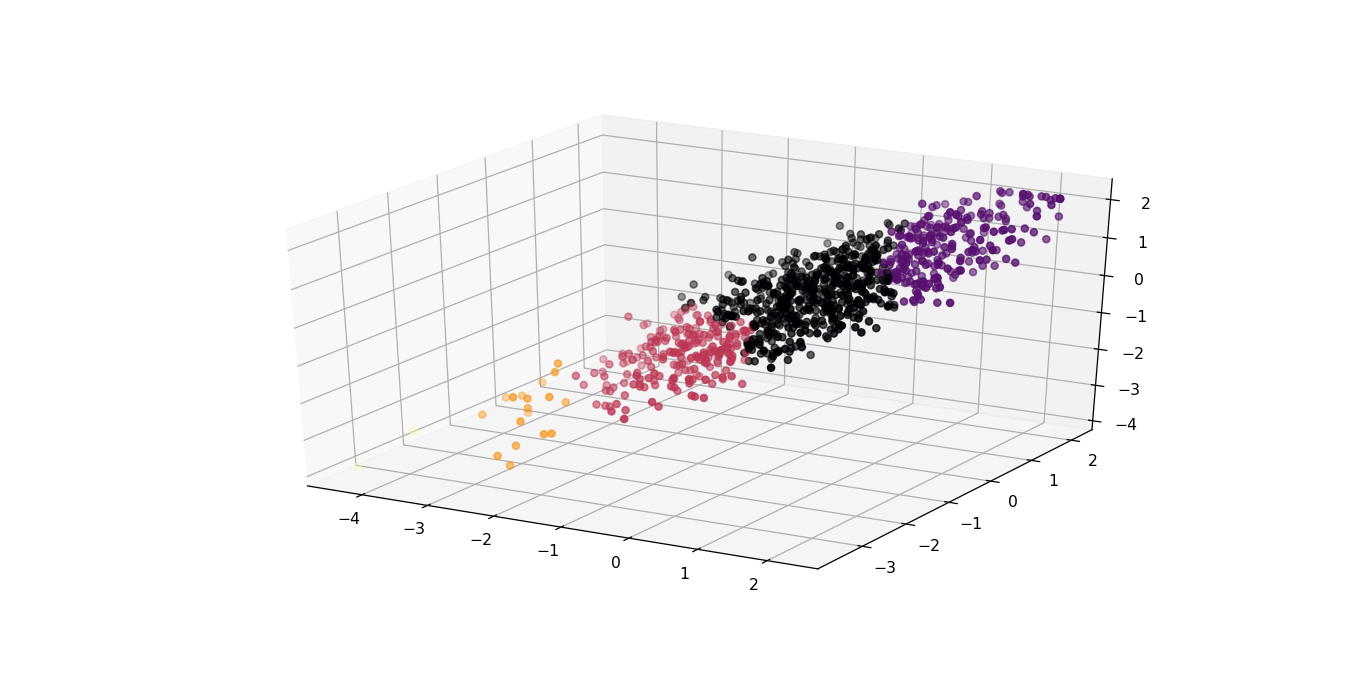

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-complete ---------------------
Davies-Bouldin index (lower->better) : 0.783758589162428
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.323
Calinski-Harabasz score (higher->better): 838.178
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


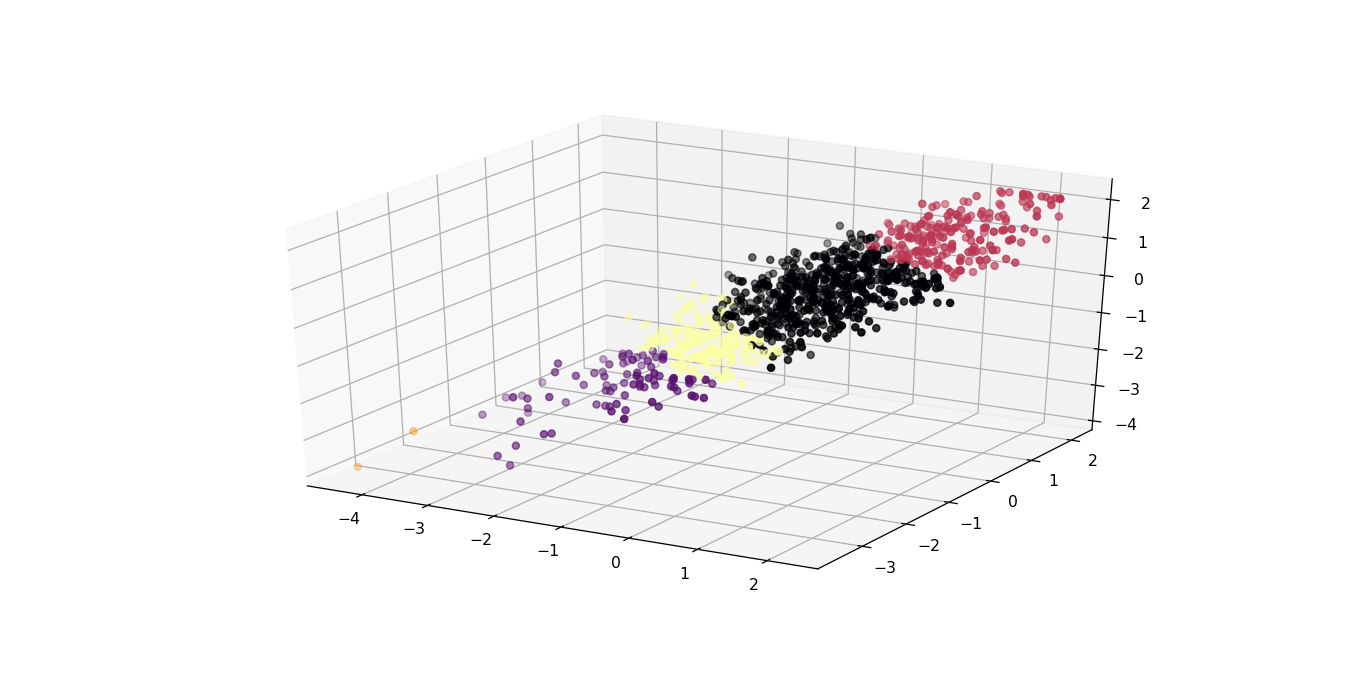

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-single ---------------------
Davies-Bouldin index (lower->better) : 0.559913572049552
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): -0.037
Calinski-Harabasz score (higher->better): 9.052
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


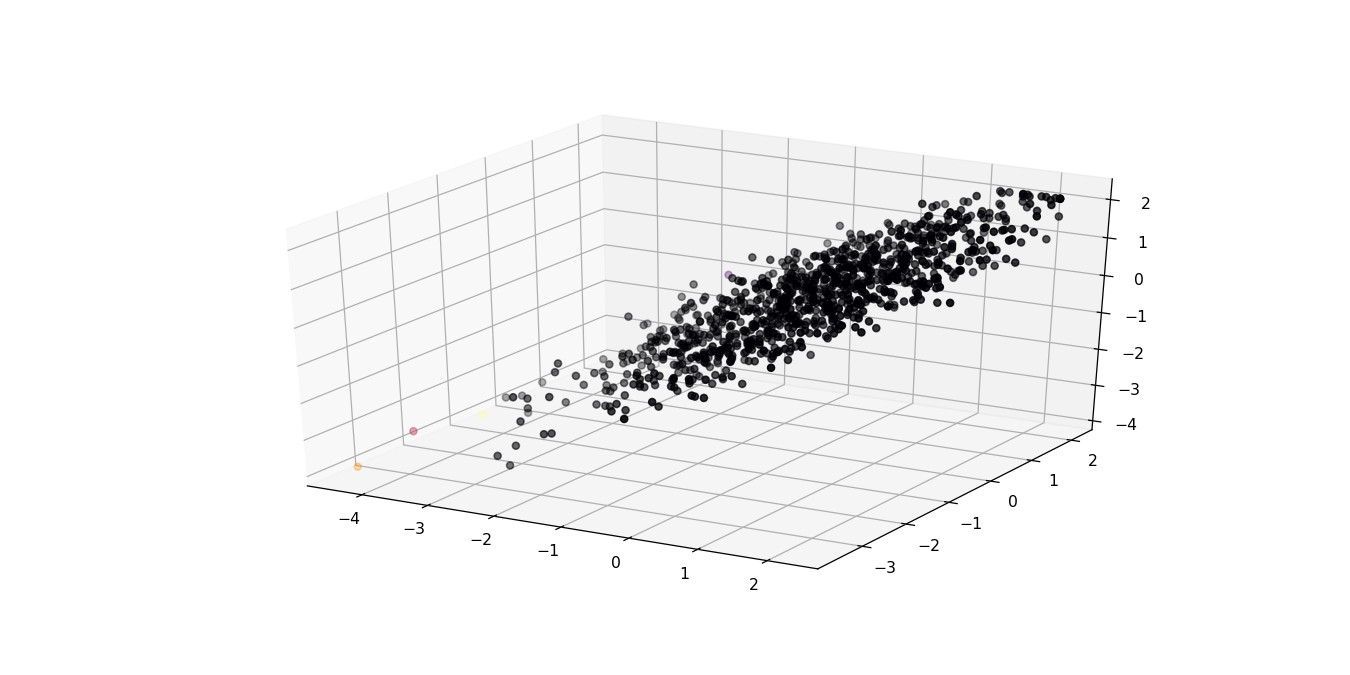

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-full ---------------------
Davies-Bouldin index (lower->better) : 0.9261387943573173
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.321
Calinski-Harabasz score (higher->better): 1194.474
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


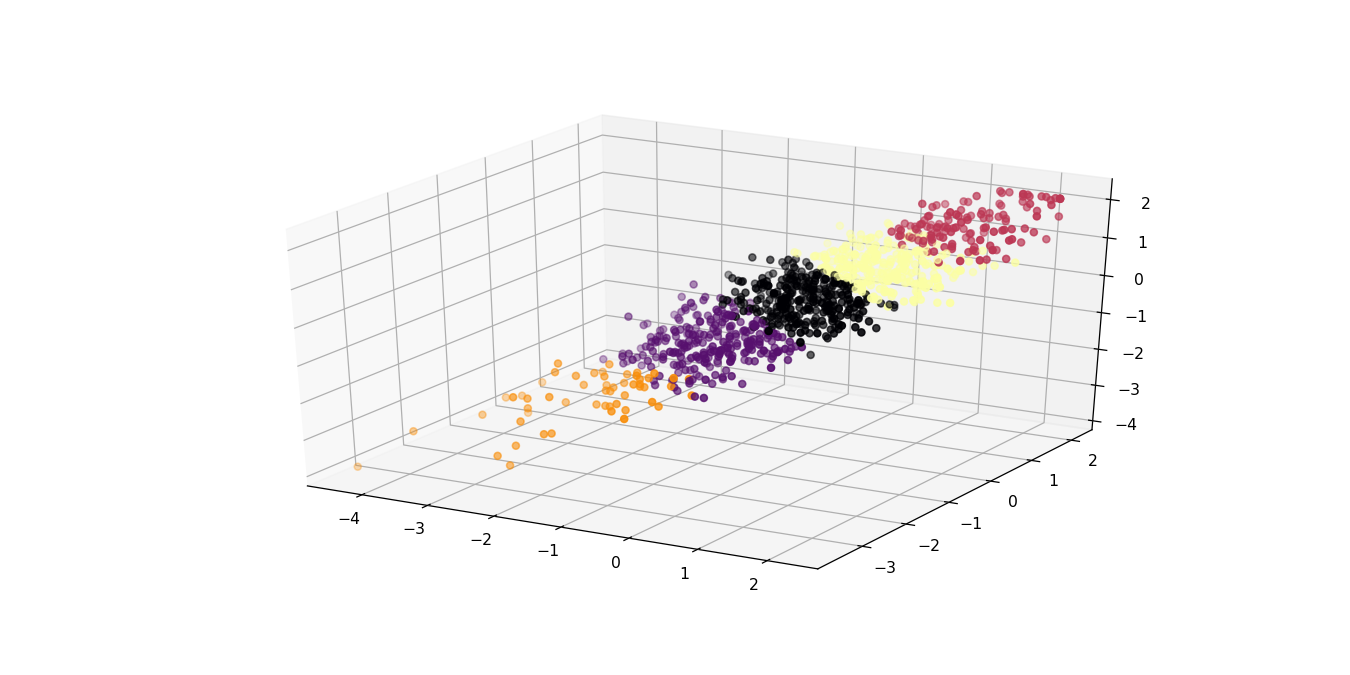

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-tied ---------------------
Davies-Bouldin index (lower->better) : 0.8211087108013781
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.344
Calinski-Harabasz score (higher->better): 1172.970
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


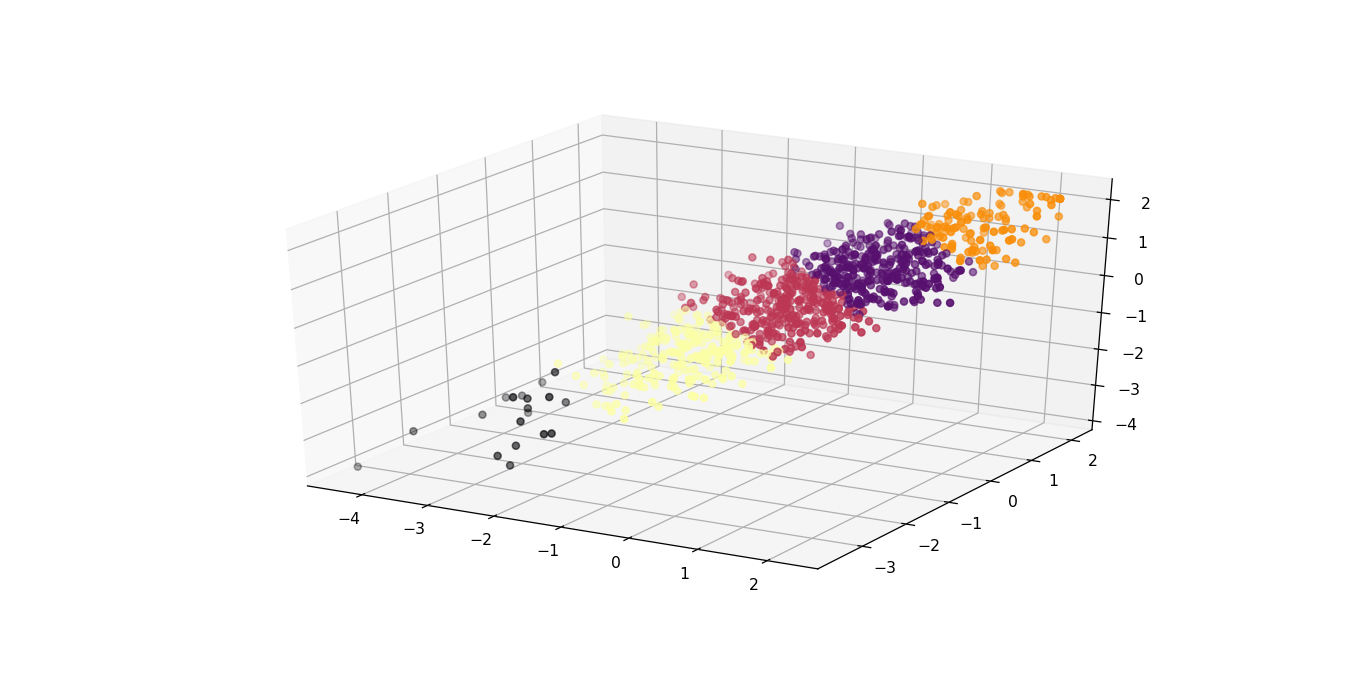

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-diag ---------------------
Davies-Bouldin index (lower->better) : 0.9514386644172077
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.313
Calinski-Harabasz score (higher->better): 1168.226
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


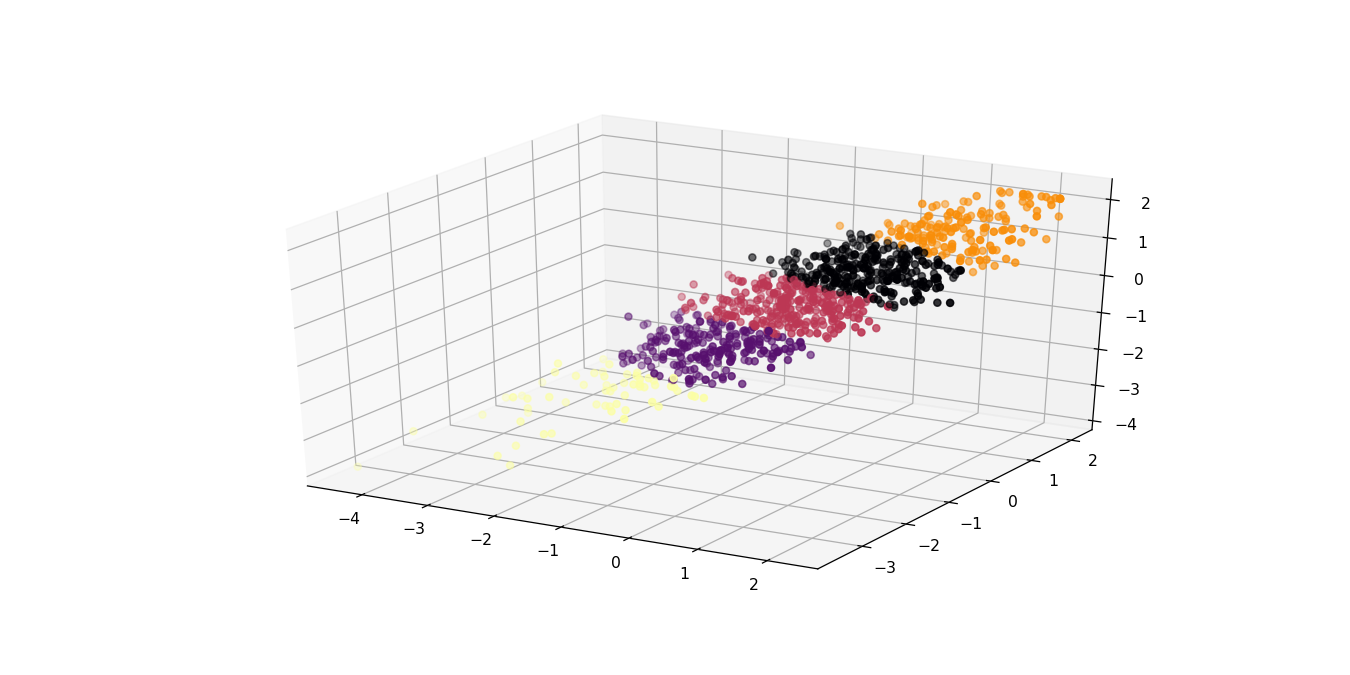

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-spherical ---------------------
Davies-Bouldin index (lower->better) : 0.8968580289875204
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.338
Calinski-Harabasz score (higher->better): 1253.458
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


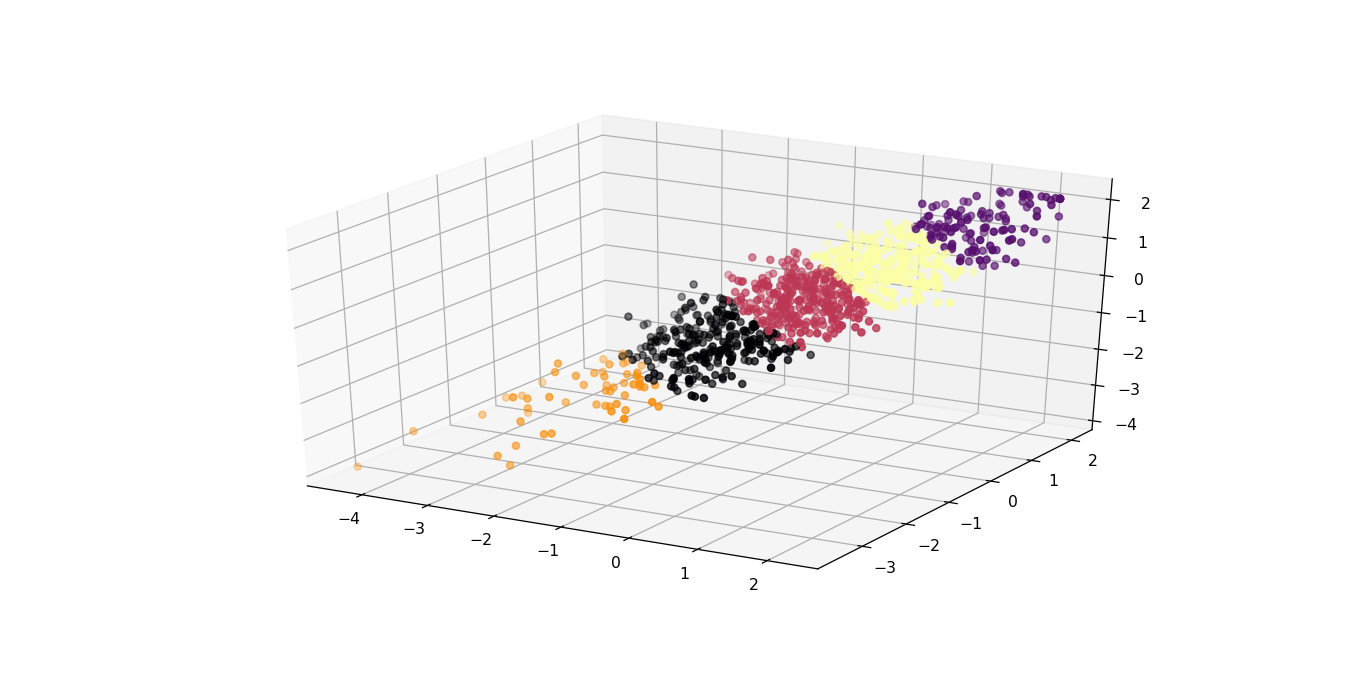

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: DBSCAN ---------------------
Davies-Bouldin index (lower->better) : 1.8767767379065545
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): -0.364
Calinski-Harabasz score (higher->better): 33.063
n_clusters_: 6
n_noise_: 109


<IPython.core.display.Javascript object>


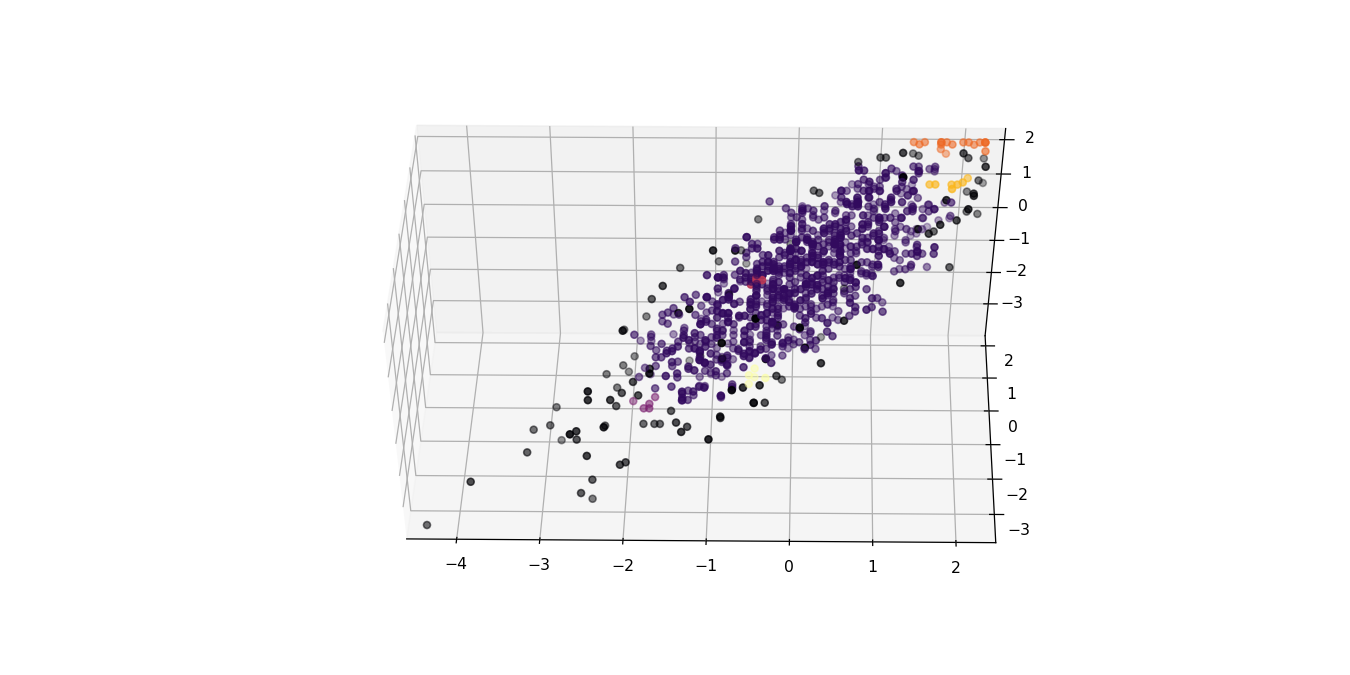

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: OPTICS ---------------------
Davies-Bouldin index (lower->better) : 4.575642183761095
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): -0.251
Calinski-Harabasz score (higher->better): 15.585
n_clusters_: 4
n_noise_: 679


<IPython.core.display.Javascript object>


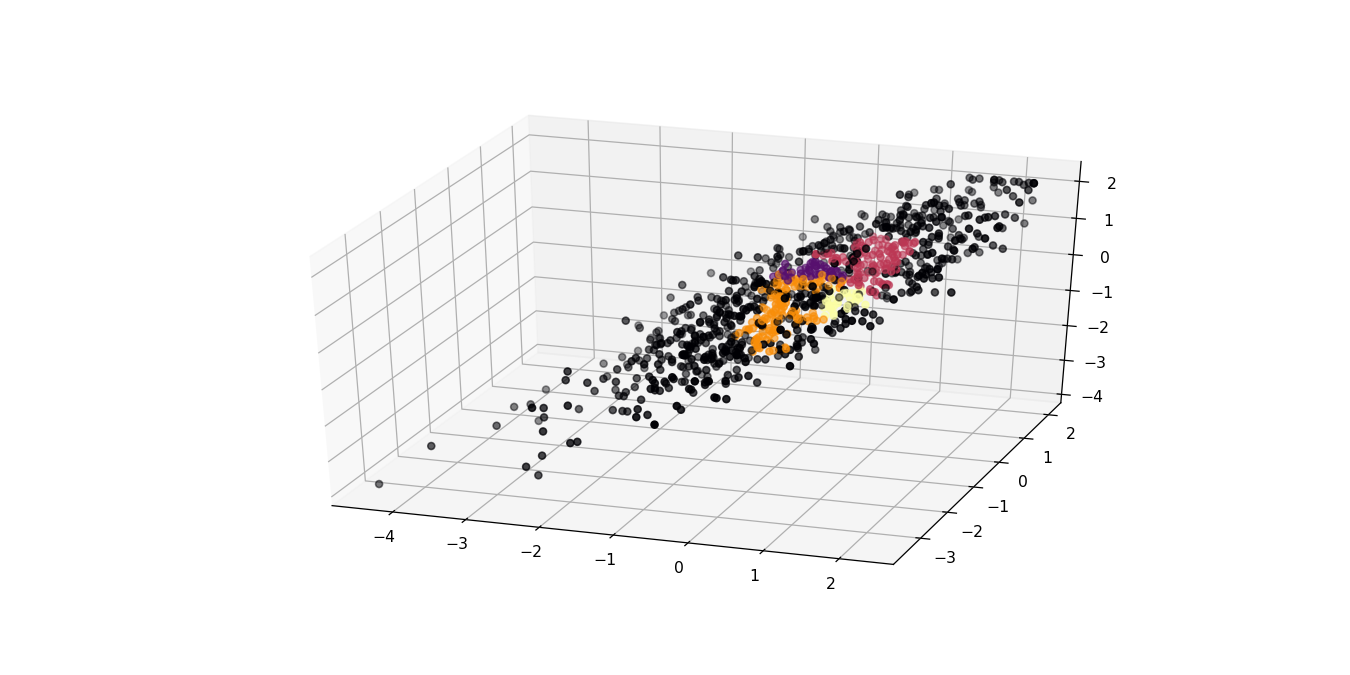

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: KMeans ---------------------
Davies-Bouldin index (lower->better) : 0.9252948154296521
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.334
Calinski-Harabasz score (higher->better): 1265.084
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


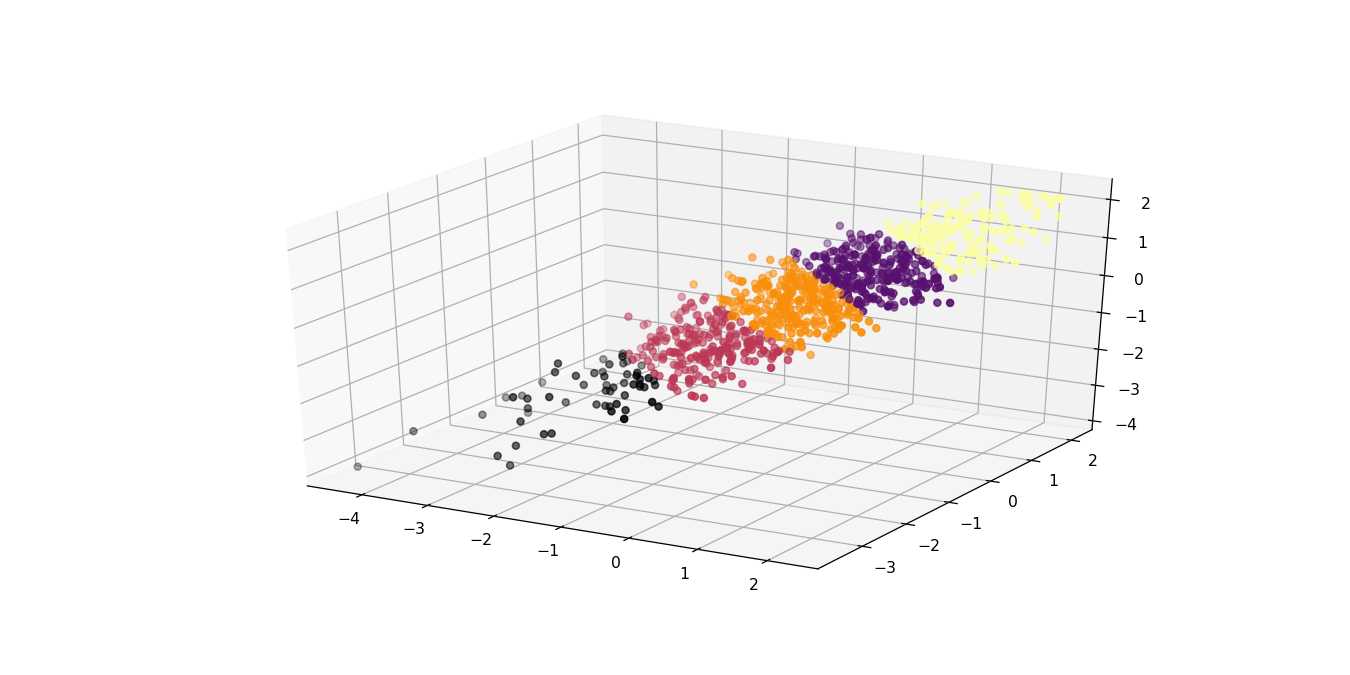

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: FCM ---------------------
Davies-Bouldin index (lower->better) : 0.9712052258219506
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.318
Calinski-Harabasz score (higher->better): 1243.294
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


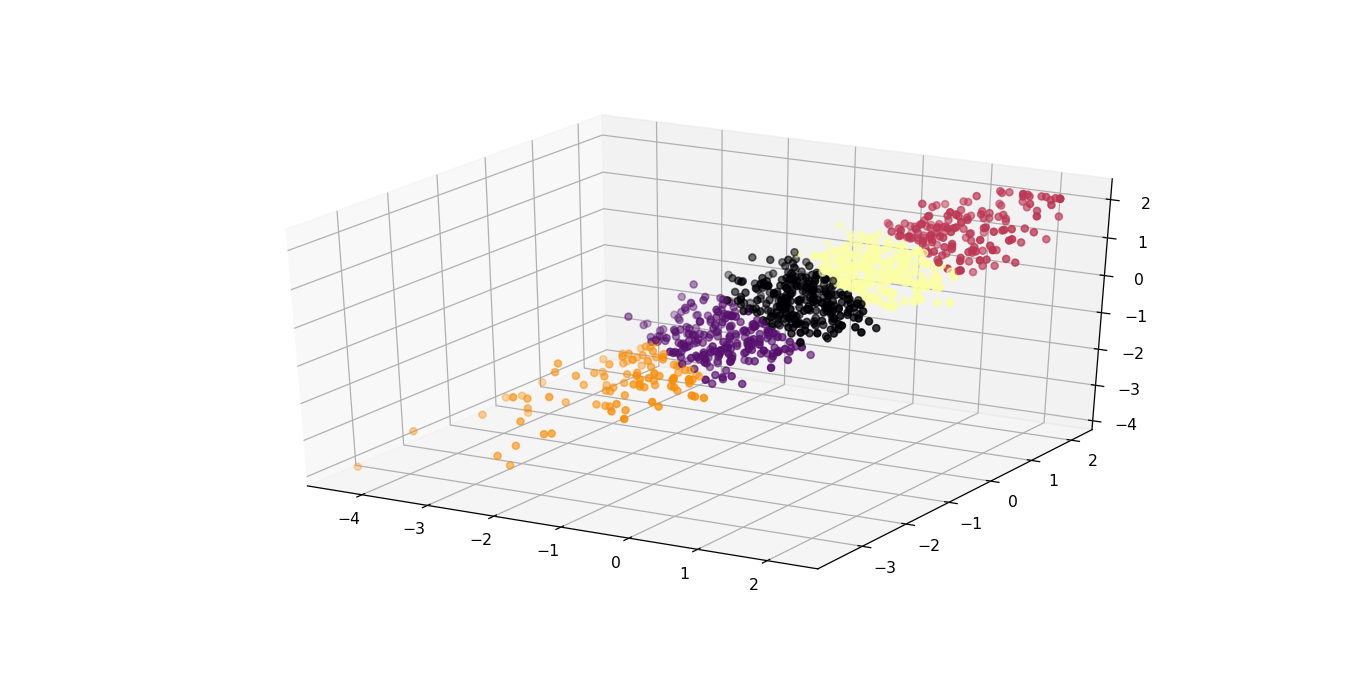

In [184]:
json_config ="""
{
    "dataSourceUrl": "/home/jovyan/host-note/data/StudentsPerformance.csv",
    "dataDelimiter": ",",
    "n_clusters": 5,
    "eps": 0.25,
    "min_samples": 4,
    "xi": 0.05,
    "min_cluster_size": 0.03,
    "m": 2,
    "ndims": 3
}"""
config = json.loads(json_config, object_hook = as_config)
main(['math score','reading score', 'writing score'])


radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,1
20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902,1
19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02

<IPython.core.display.Javascript object>


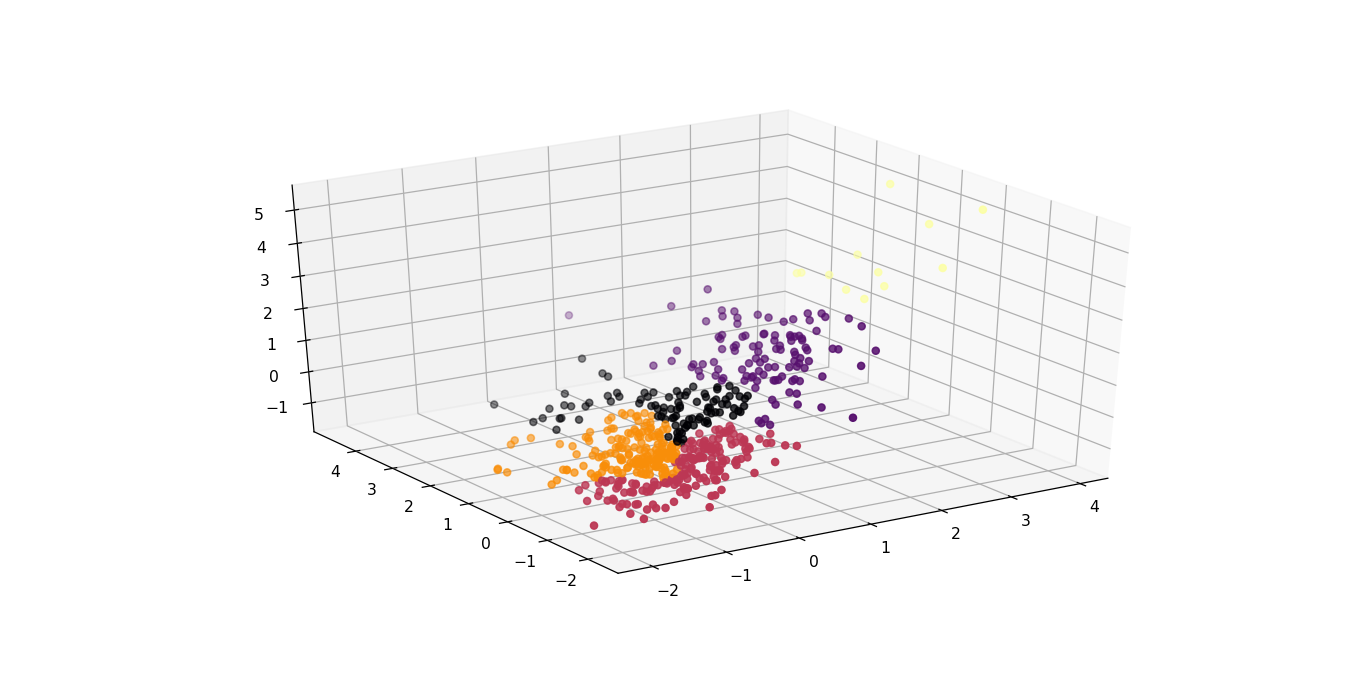

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-average ---------------------
Davies-Bouldin index (lower->better) : 0.6240663483902668
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.428
Calinski-Harabasz score (higher->better): 234.020
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


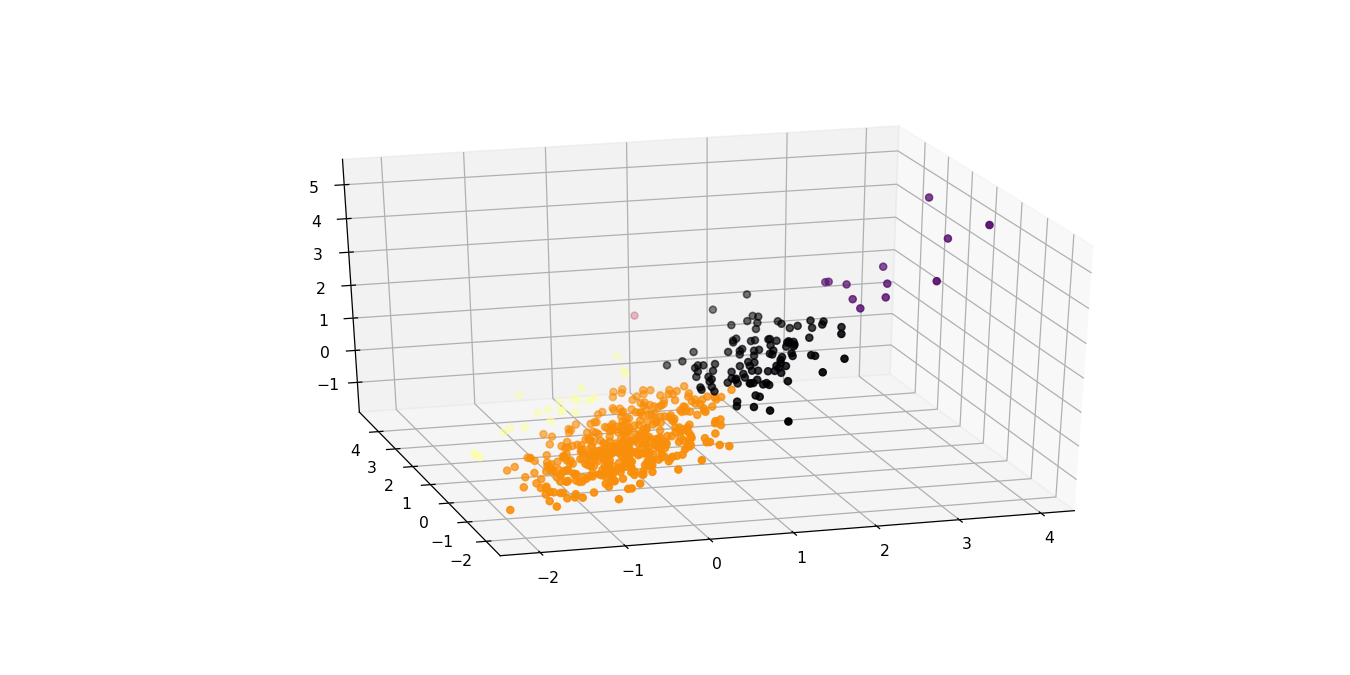

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-complete ---------------------
Davies-Bouldin index (lower->better) : 0.9848068563250232
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.256
Calinski-Harabasz score (higher->better): 206.987
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


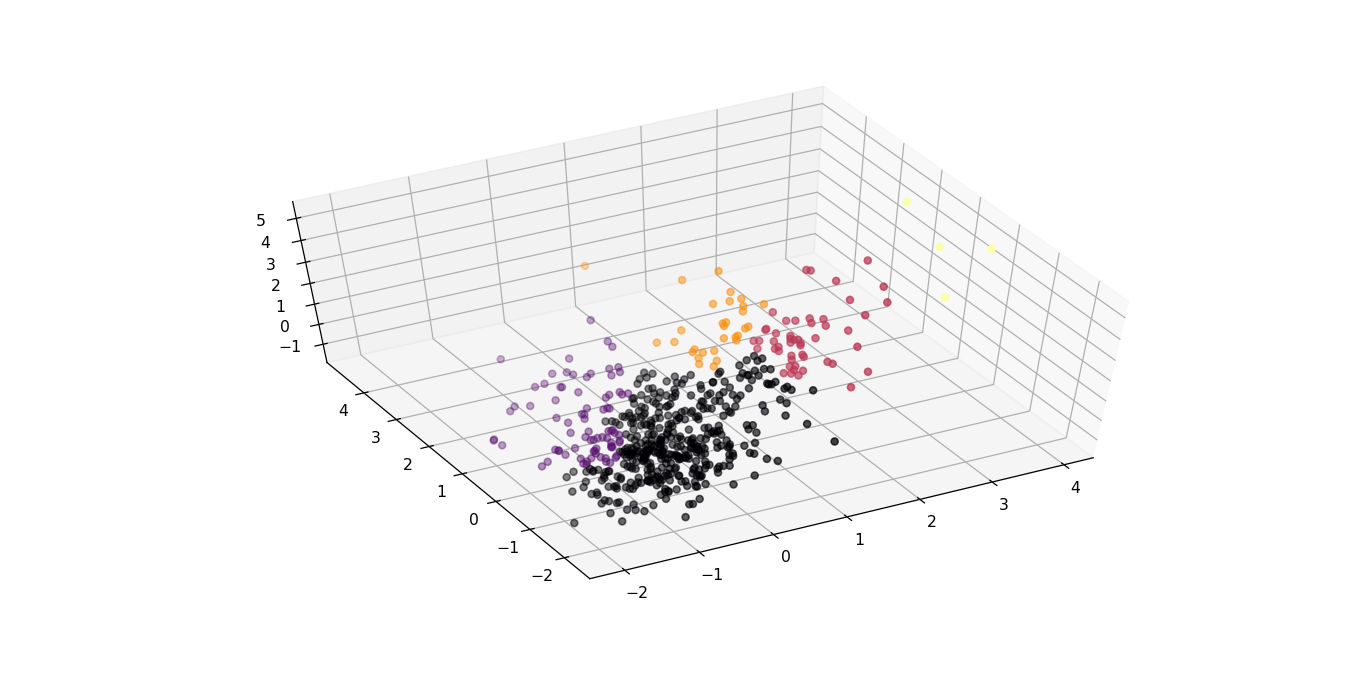

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: AgglomerativeClustering-single ---------------------
Davies-Bouldin index (lower->better) : 0.2551102443613852
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.534
Calinski-Harabasz score (higher->better): 13.232
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


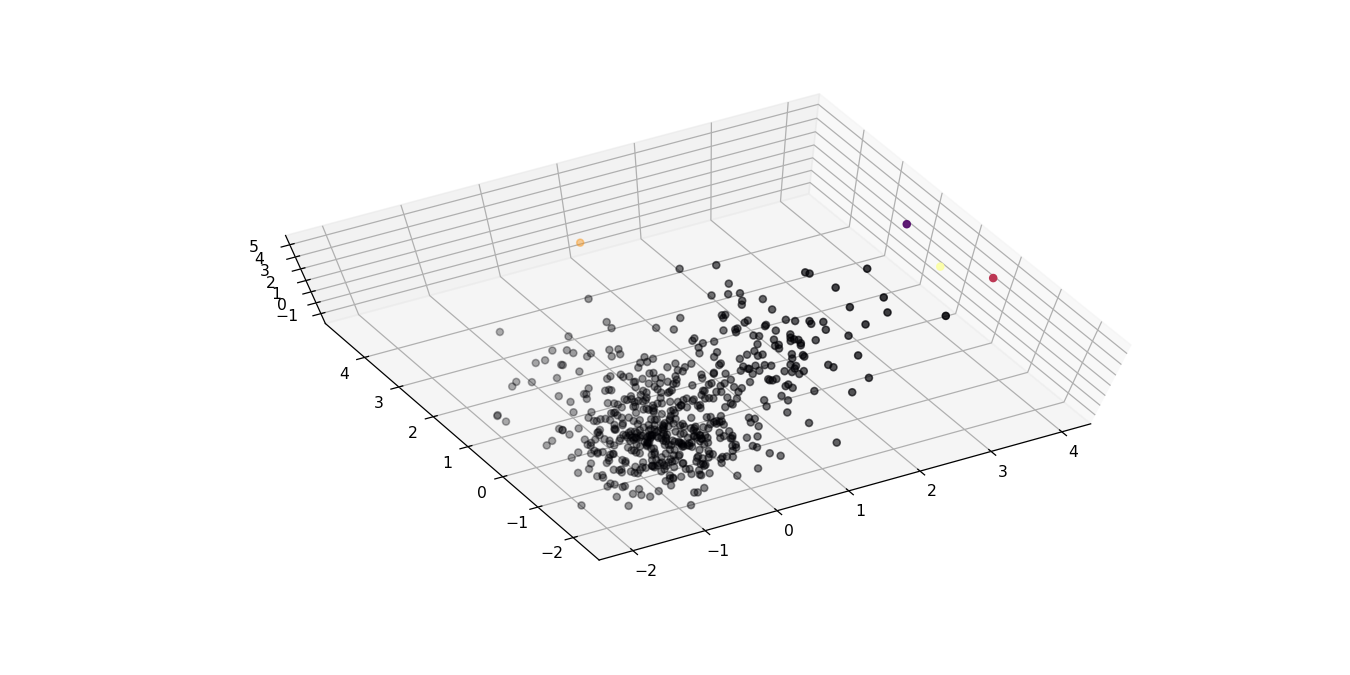

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-full ---------------------
Davies-Bouldin index (lower->better) : 1.471975041109299
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.187
Calinski-Harabasz score (higher->better): 220.084
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


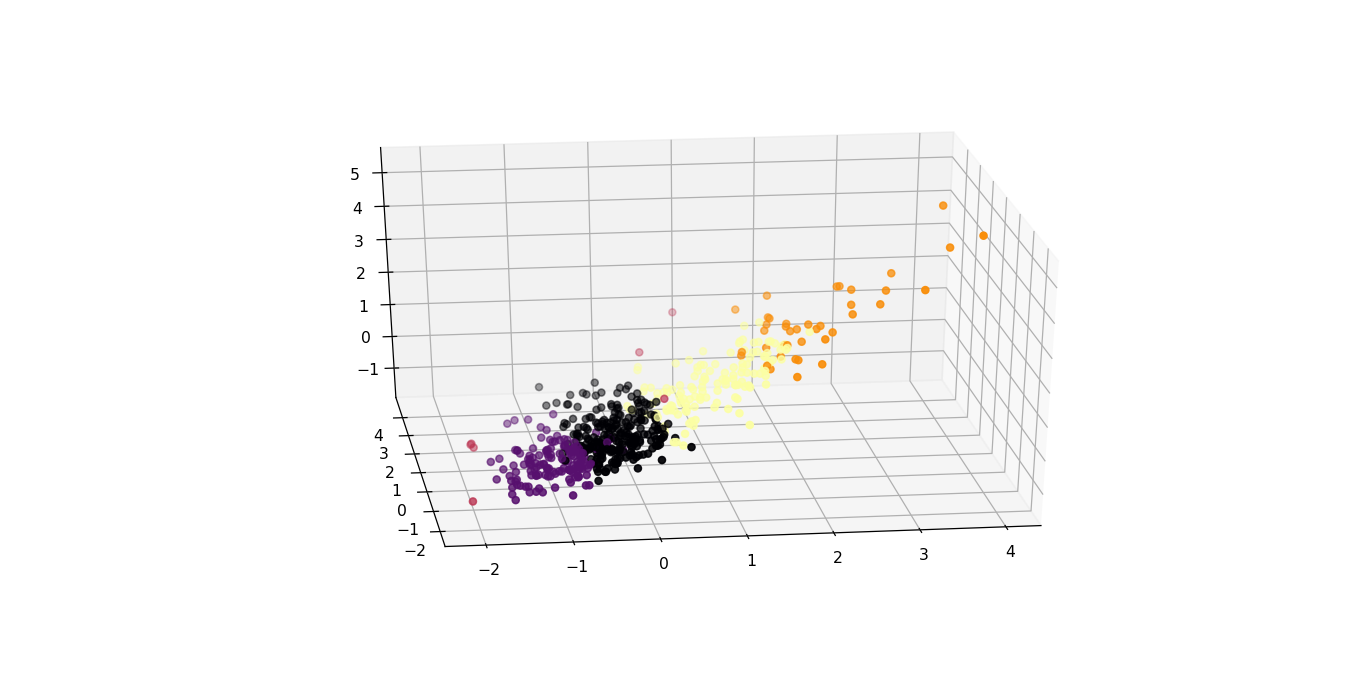

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-tied ---------------------
Davies-Bouldin index (lower->better) : 0.9371934871552364
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.267
Calinski-Harabasz score (higher->better): 292.310
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


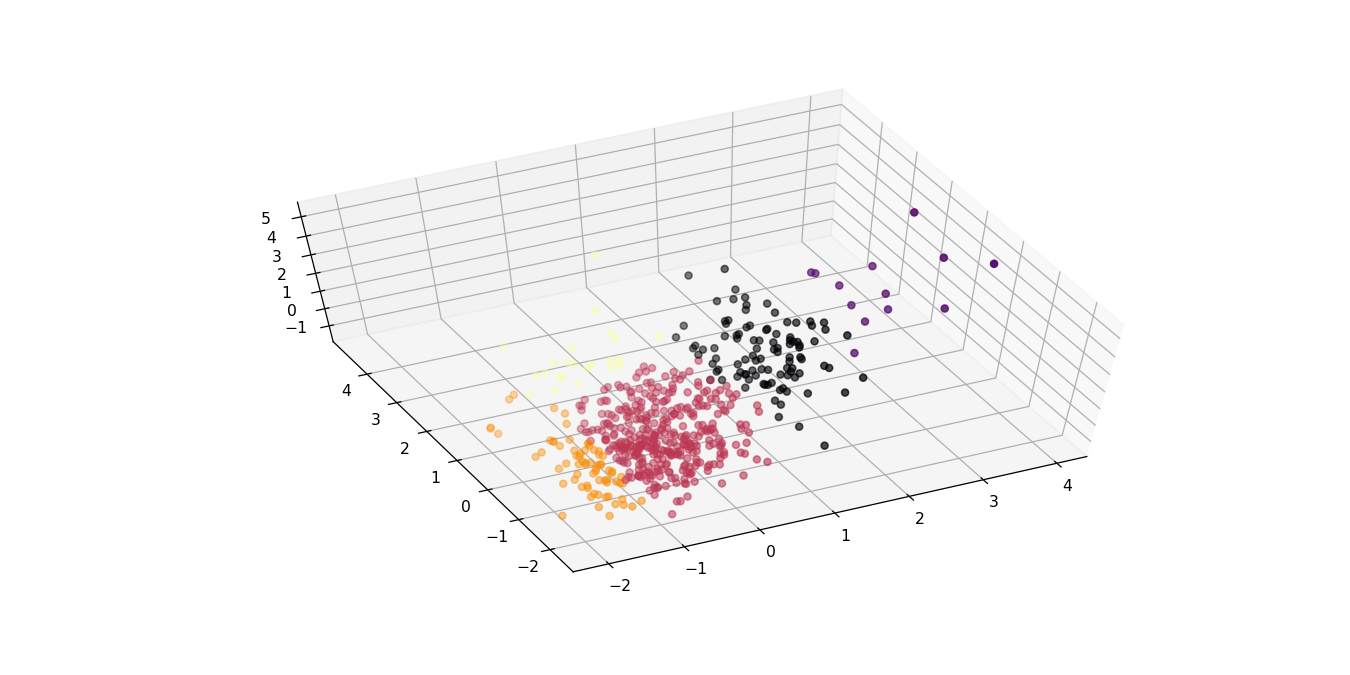

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-diag ---------------------
Davies-Bouldin index (lower->better) : 1.780310303195201
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.165
Calinski-Harabasz score (higher->better): 243.716
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


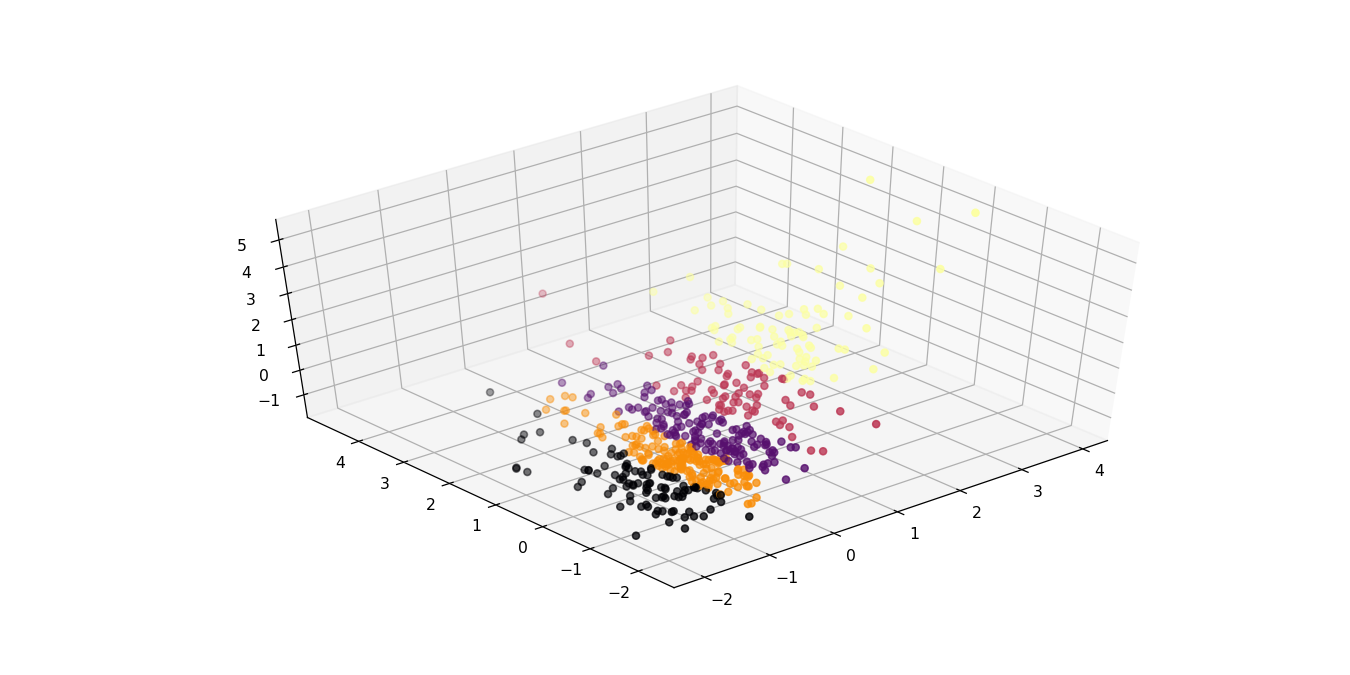

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: GaussianMixture-spherical ---------------------
Davies-Bouldin index (lower->better) : 0.9423103379024098
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.302
Calinski-Harabasz score (higher->better): 398.316
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


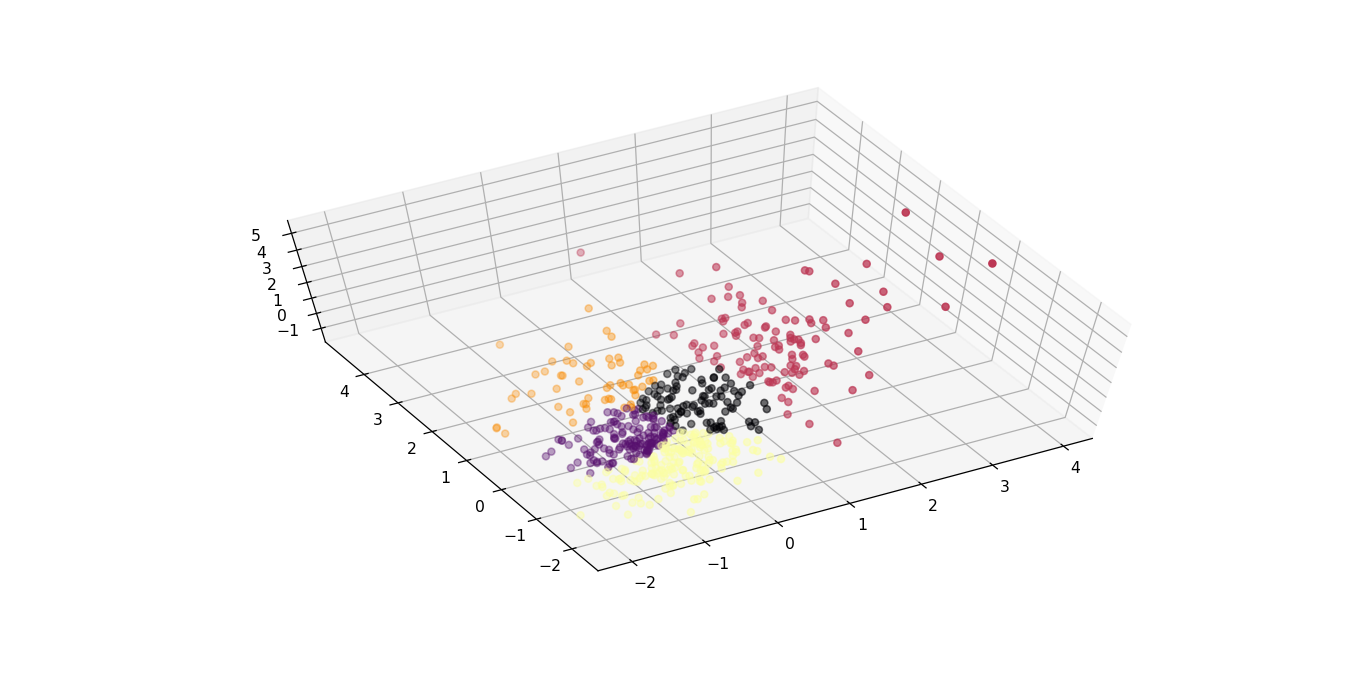

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: DBSCAN ---------------------
Davies-Bouldin index (lower->better) : 2.2820459391399264
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.126
Calinski-Harabasz score (higher->better): 25.845
n_clusters_: 7
n_noise_: 60


<IPython.core.display.Javascript object>


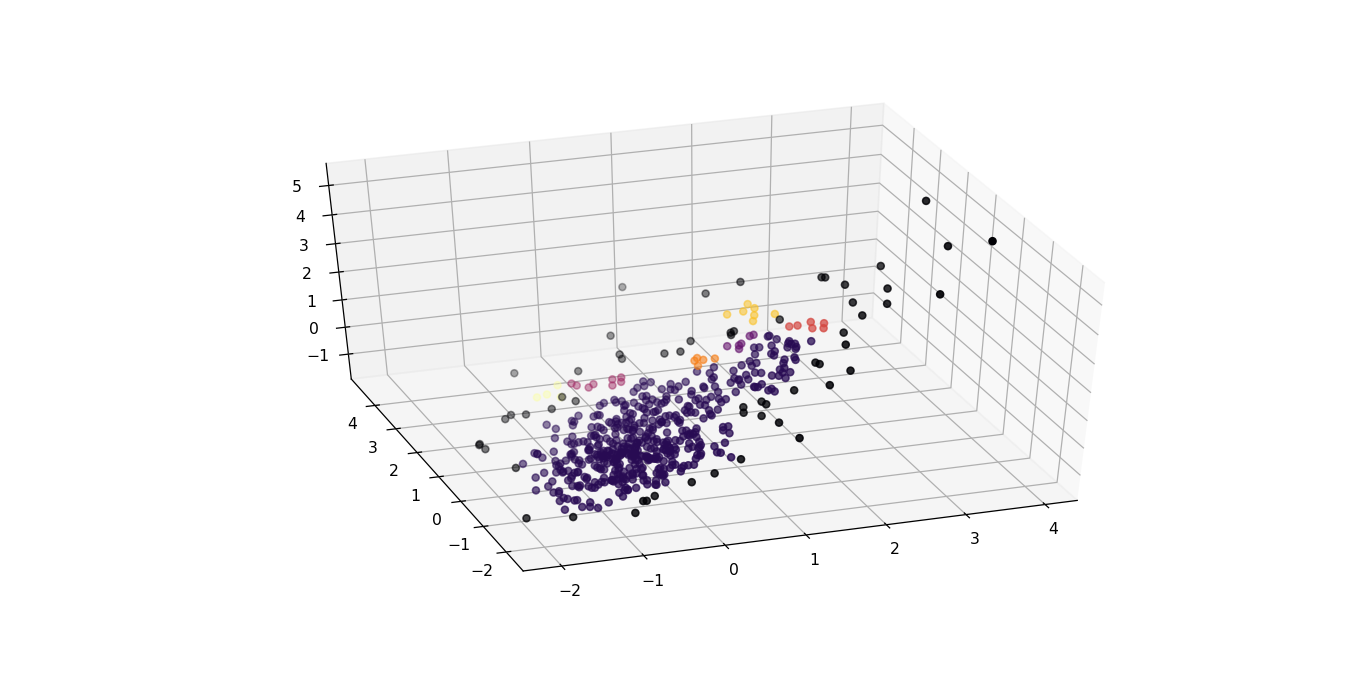

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: OPTICS ---------------------
Davies-Bouldin index (lower->better) : 1.7154687140398195
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): -0.243
Calinski-Harabasz score (higher->better): 9.599
n_clusters_: 2
n_noise_: 532


<IPython.core.display.Javascript object>


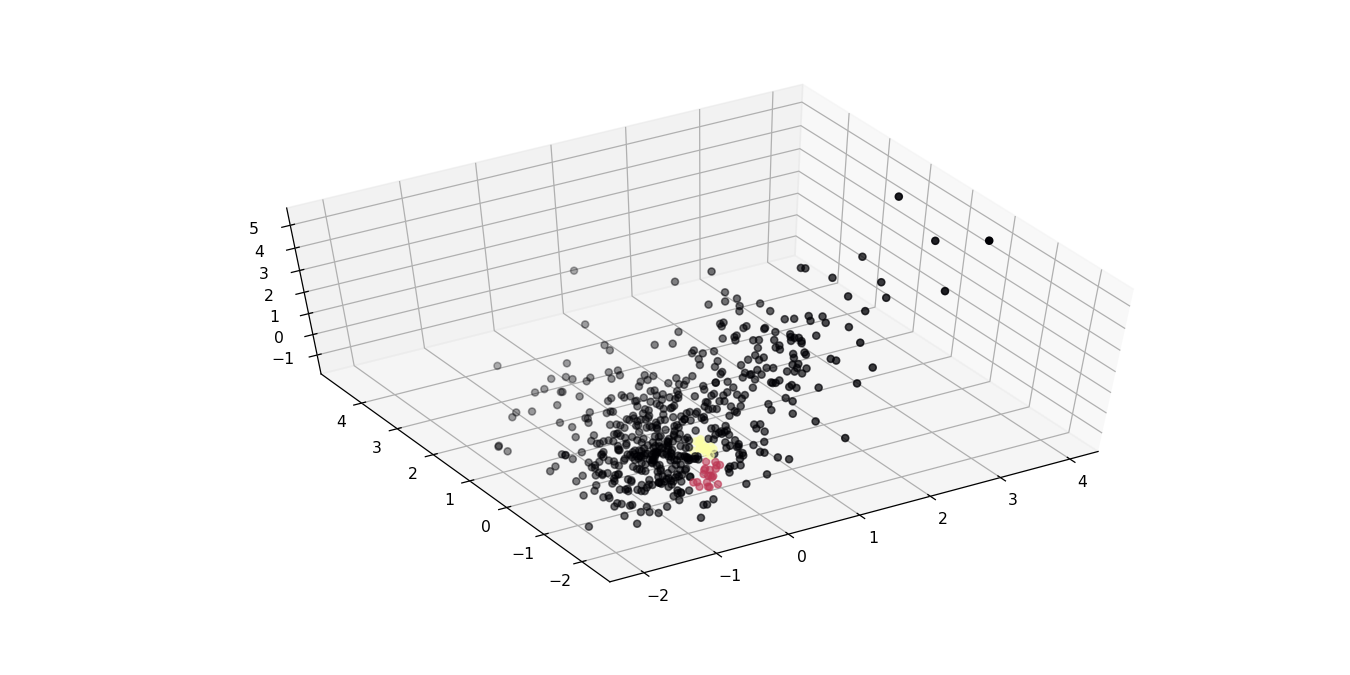

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: KMeans ---------------------
Davies-Bouldin index (lower->better) : 0.9209761374623445
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.340
Calinski-Harabasz score (higher->better): 441.515
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


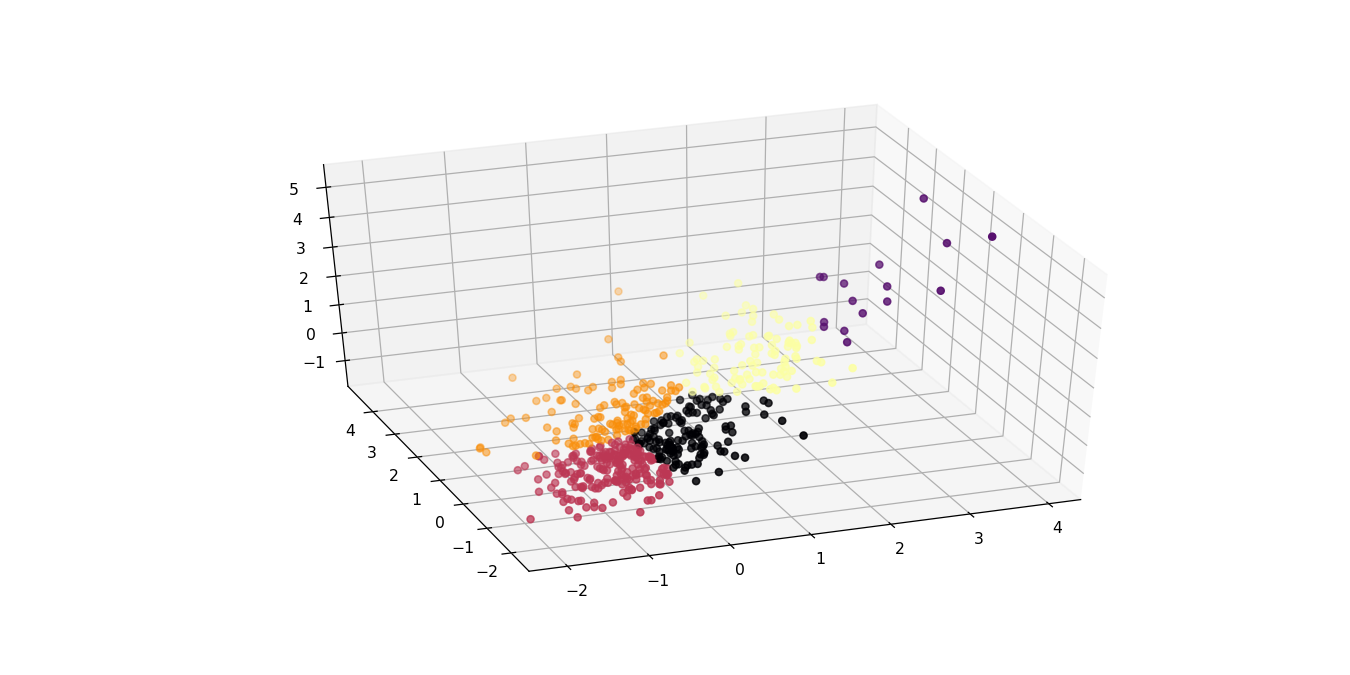

-------------------------------------------------------------------------------------------
--------------------- Running clustering for: FCM ---------------------
Davies-Bouldin index (lower->better) : 1.0293268053886888
Silhouette Coefficient (-1->bad, 0->clusters overlap, 1+->better): 0.304
Calinski-Harabasz score (higher->better): 430.803
n_clusters_: 5
n_noise_: 0


<IPython.core.display.Javascript object>


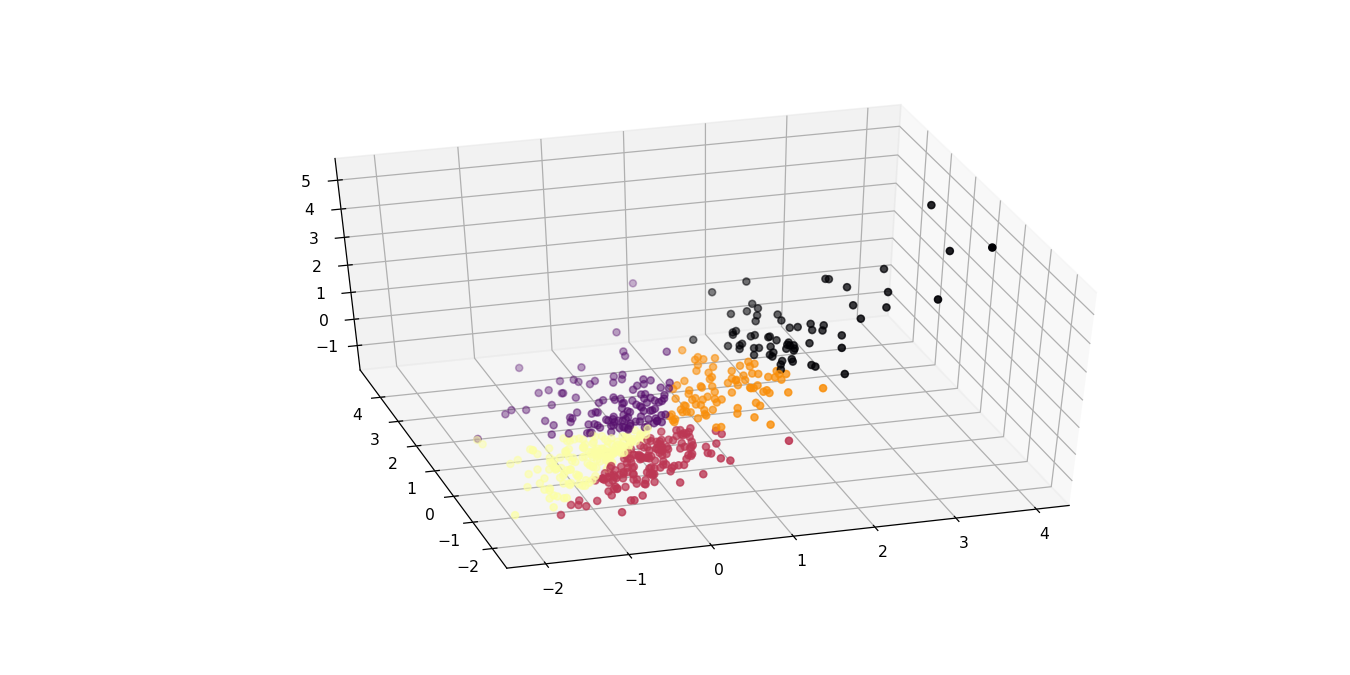

In [185]:
json_config ="""
{
    "dataSourceUrl": "/home/jovyan/host-note/data/cancer.csv",
    "dataDelimiter": ",",
    "n_clusters": 5,
    "eps": 0.3,
    "min_samples": 4,
    "xi": 0.1,
    "min_cluster_size": 0.03,
    "m": 2,
    "ndims": 3
}"""
config = json.loads(json_config, object_hook = as_config)
main(['radius_mean','texture_mean', 'area_mean'])

<h1><center>Wnioski</center></h1>
<p><ul style="list-style: none;text-align: justify;text-justify: inter-word">
    <li>Algorytm FCM dla współczynnika m = 2 daje bardzo podobne rezultaty do KMeans
przy czym FCM osiąga lepszy indeks Daviesa-Bouldina KMeans lepszy wynik Calinskiego-Harabasza.
Natomiast przy trzech wymiarach FCM jest wyraźnie gorszy od KMeans.</li>
    <br/>
    <li>Dla metody hierarchicznej – aglomeracyjnej:<br/>
Zastosowanie metody pojedynczego wiązania w metodzie aglomeracyjnej powoduje powstawanie dużej liczby klastrów składających się z bardzo małej liczby obserwacji. Wynika to z tego, że opiera swoje działanie na łączenie w "łańcuchy" najbliższych sobie obserwacji i jeśli są one znacznie odstające od pozostałych elementów to nie zostaną z nimi połączone. Prowadzi to do powstania jednego klastra zawierającego większość obserwacji równocześnie z bardzo małymi klastrami.
W przypadku metod kompletnego wiązania, średniej oraz Warda elementy są równiej rozdzielone w klastrach i mają tendencję do tworzenia owalnych kształtów, radzą sobie lepiej z elementami odstającymi. Owalność klastrów widać np. w porównaniu do metody EM. Metoda średniego połączenia klastrów ma spośród tych trzech największą tendencję do grupowania elementów odstających jako oddzielnego klastra i tworzenia równocześnie stosunkowo dużych klastrów o gęstym położeniu elementów, które w przypadku połączeń Warda oraz kompletnego wiązania rozbijane są na oddzielne klastry. W przypadku metody kompletnych łączeń wynika to ze znacznej odległości punktów maksymalnie oddalonych w takich klastrach, natomiast metoda Warda dąży do minimalziacji sumy kwadratów odchyleń klastrów.
</li><br/>
    <li>Metoda ma ta najlepsze zastosowanie gdy rozkład cech zachowuje podobne odległości między sobą. Wówczas z łatwością KMeans potrafi przypisać członków do danego klastra. Gorzej radzi w przeciwnym przypadku. Wówczas może mylnie przypisać członków do klastra, ponieważ jego odległość od centroidu będzie większa, niż dla prawidłowego klastra. Na przykładzie zbioru USArrests, metoda łokcia wskazała najlepszy wynik dla 3 klastrów. Jednakże przy wyborze 4 klastrów na wykresie może z sukcesem odnaleźć 4 cechy. Wynik jest podobny do działania FCM, co może wskazywać na ułomność metody "łokcia". Również ten algorytm ma tendencję do tworzenia klastrów o równej liczebności członków, stąd może wynikać preferowanie wyboru 3 klastrów dla wyżej opisanego przypadku, zamiast 4. To też widać na wykresie ze zbioru StudentsPerformance, gdzie zasugerowano 3 klastry.</li><br/>
    <li>Metoda GMM jest elastyczna i może przynosić różne wyniki w związku z możliwością wyboru kowariancji. Na wizualizacjach można zaobserwować różne kształty klastrów (np. sferyczne i diagonalne) oraz ich nachodzenie. Można również zauważyć podstawową różnicę między K-means, który dostarcza jednoznacznych przyporządkowań (jedynie w postaci sferycznych grup) oraz GMM, który dostarcza przyporządkowań miękkich zależnych od wybranej kowariancji. W związku z „miękkością” tej metody, należy do niej podchodzić z dużą rezerwą i opierać na niej ostateczne wyniki w sytuacji, w której dane rzeczywiście spełniają rozkład Gaussa.
</li> <br/>
    <li>Dla DBSCAN oraz OPTICS:</li>
    <li>Algorytmy te tworzą klastry w obszarach o dużym zagęszczeniu obserwacji, dzięki czemu mogą być użyteczne do wykrycia nawet niewielkich obszarów o wyróżniającym się zagęszczeniu, mogących reprezentować zakresy wartości o szczególnym znaczeniu</li>
    <li>Do poprawnego działania algorytmu należy skonfigurować parametry sterujące ich działaniem dokładnie do potrzeb danego zbioru danych. Nawet niewielkie zmiany mogą powodować drastycznie odmienne wyniki, stąd niezbędne może być używanie heurystyk ułatwiających znalezienie skutecznych parametrów</li>
    </ul>
</p>